# **Forecasting Walmart Weekly Sales using Machine Learning**  
![](https://i.imgur.com/qwvOeHo.jpg)

Open in Google Colab and click the "Run" button to execute the code.

Walmart is an American Retail, Wholesale and E-commerce business. Sam Walton founded Walmart in 1962 in Rogers, Arkansas. His goal was to help people "Save Money and Live Better" which continues to be Walmart's guiding mission with "Every Day Low Prices(EDLC)" and great service. 
- Number 1 ranked [Fortune 500](https://fortune.com/fortune500/) company with [total revenue](https://s2.q4cdn.com/056532643/files/doc_financials/2021/ar/WMT_2021_AnnualReport.pdf) of $559 billion as of Jan 31 2021. 
- Publicly listed company, 'WMT' on the New York Stock Exchange(NYSE)
- Each week 220 million customers visit 10,500 stores and clubs under 48 banners in 24 countries and eCommerce websites
- [Largest](https://www.statista.com/statistics/264671/top-50-companies-based-on-number-of-employees/) private employer in the world with more than 2.3 million people employed around the world


Revenue and operations of the company are categorised into three key business segments - Walmart US, Walmart International and Sam's Club.

They operate in three store types or store formats as below.
- Supercenters (general merchandise and grocery, Average store size 178,000 square feet)
- Discount stores (general merchandise and limited grocery, Average size 106,000 square feet)
- Neighbourhood stores (grocery, Average size 42, 000 square feet)


The business problem is to forecast weekly store sales for Walmart.

### Business problem statement

1. Predicting department-wide weekly sales for each Walmart store
2. Predict which departments are affected and the extent of the impact due to holiday markdowns based on limited history


**Evaluation criteria and loss functions**  
 WMAE - weighted mean absolute error
    
$$WMAE = \frac{1}{\Sigma w_i} * \sum_{i=1}^{+n} w_i * | y_i - \hat{y}_i|$$


where

n is the number of rows  
\\( \hat{y}_i \\) is the predicted sales  
\\( y_i \\) is the actual sales  
\\( w_i \\) are weights. w = 5 if the week is a holiday week, 1 otherwise

In this notebook we will explore Supervised Machine Learning methods. Regression models such as linear regression, decision tree and ensemble models such as RandomForest, XGBoost, LightGBM will trained to predict weekly sales using **Scikit Learn**, **LightGBM** and **XGBoost**.  We will use **Pandas**, **Numpy**, **Matplotlib**, **Seaborn** and **Plotly** to perform exploratory data analysis and gather insights for machine learning. We will do the following

- Install and Import libraries
- Explore the dataset and merge different files as required
- Translate the business problem to a machine learning problem
- EDA - exploratory data analysis
- Feature Engineering
- Data preparation - Train Val Split, Encoding, Imputing and Scaling
- Select input features
- Define evaluation metrics
- Define baseline model
- Select best model without hyperparameter tuning
- Hyperparameter tuning for select models
- Make predictions
- Save the best model
- Summarise insights and learning


### Install and import libraries

In [4]:
#!pip install pandas numpy sklearn opendatasets seaborn matplotlib plotly --upgrade --quiet

In [5]:
!pip install opendatasets --upgrade --quiet

In [6]:
# OS and Data libraries
import os
import opendatasets as od
from zipfile import ZipFile

#Data analysis libraries
import numpy as np
import pandas as pd

#Visualisation libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#date formatters
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

#Jupyter notebook visualisation font and figure display parameters
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Exploring the dataset

#### Download and extract data from zip files

In [7]:
kaggle_url = "https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data"

In [8]:
od.download(kaggle_url)

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


In [9]:
!ls -lh

total 8.0K
drwxr-xr-x 1 root root 4.0K Sep 30 17:12 sample_data
drwxr-xr-x 2 root root 4.0K Oct  3 11:23 walmart-recruiting-store-sales-forecasting


In [10]:
os.listdir("walmart-recruiting-store-sales-forecasting")

['train.csv',
 'sampleSubmission.csv',
 'test.csv.zip',
 'features.csv.zip',
 'test.csv',
 'features.csv',
 'sampleSubmission.csv.zip',
 'stores.csv',
 'train.csv.zip']

In [11]:
# Helper function to unzip many ".zip" files in a directory

from zipfile import ZipFile

def unzip_files(path):
    
    # Get list of files in the directory
    files = os.listdir(path)
    
    for file in files:                                   #For each file in the directory
        
        if file.endswith(".zip"):                        # if it is a ".zip" file
            file_path = path+"/"+file                    # get location of the file
            
            with ZipFile(file_path,"r") as zip_file:     #Open the ".zip" file in read mode
                zip_file.extractall(path)                #extract all files in ".zip" in the location
    
    return     

In [12]:
dir_path = "./walmart-recruiting-store-sales-forecasting"

#unzip all ".zip" files
unzip_files(dir_path)

os.listdir("walmart-recruiting-store-sales-forecasting")

['train.csv',
 'sampleSubmission.csv',
 'test.csv.zip',
 'features.csv.zip',
 'test.csv',
 'features.csv',
 'sampleSubmission.csv.zip',
 'stores.csv',
 'train.csv.zip']

In [13]:
import glob

glob.glob(dir_path+"/"+"*.csv")

['./walmart-recruiting-store-sales-forecasting/train.csv',
 './walmart-recruiting-store-sales-forecasting/sampleSubmission.csv',
 './walmart-recruiting-store-sales-forecasting/test.csv',
 './walmart-recruiting-store-sales-forecasting/features.csv',
 './walmart-recruiting-store-sales-forecasting/stores.csv']

In [14]:
train_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/train.csv')
test_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/test.csv')
stores_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/stores.csv')
features_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/features.csv')
submission_df = pd.read_csv('./walmart-recruiting-store-sales-forecasting/sampleSubmission.csv')

#### Explore data in individual files

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [16]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.00,11.00,22.00,33.0000,45.00
Dept,421570.0,44.260317,30.492054,1.00,18.00,37.00,74.0000,99.00
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36


In [17]:
train_df.astype('object').describe().transpose()

,count,unique,top,freq
Store,421570,45,13,10474
Dept,421570,81,1,6435
Date,421570,143,2011-12-23,3027
Weekly_Sales,421570,359464,10,353
IsHoliday,421570,2,False,391909


In [18]:
train_df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

**Train.csv**
- `Store`: Store number from 1 to 45 doesnt indicate any ranking.
- `Dept`: Numbered 1 - 99. There are 81 departments in this dataset. So some stores have much fewer than 81 departments. Stores may have started some departments later
- `Date`: Date corresponding to Thursday of each week (So a week is Friday - Thursday)
- `IsHoliday`: A boolean indicating whether it is a store holiday or not
- `Weekly_Sales`: Sales for the week reported on Thursdays of each week. 
- The complete history of 143 weeks is therefore not available for all departments
- No null values in this dataset

In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [20]:
test_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,115064.0,22.238207,12.80993,1.0,11.0,22.0,33.0,45.0
Dept,115064.0,44.339524,30.65641,1.0,18.0,37.0,74.0,99.0


In [21]:
test_df.astype('object').describe().transpose()

,count,unique,top,freq
Store,115064,45,13,2836
Dept,115064,81,1,1755
Date,115064,39,2012-12-21,3002
IsHoliday,115064,2,False,106136


In [22]:
test_df.isna().sum()

Store        0
Dept         0
Date         0
IsHoliday    0
dtype: int64

**Test.csv**
- `Store`: Store number from 1 to 45 doesnt indicate any ranking.
- `Dept`: Numbered 1 - 99. 81 departments in this dataset. So some stores have much fewer than 81 departments. Stores may have started some departments later
- `Date`: Date corresponding to Thursday of each week (So a week is Friday - Thursday)
- `IsHoliday`: A boolean indicating whether it is a store holiday or not
- 39 forecast weeks
- No null values in this dataset

In [23]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [24]:
stores_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,45.0,23.0,13.133926,1.0,12.0,23.0,34.0,45.0
Size,45.0,130287.6,63825.271991,34875.0,70713.0,126512.0,202307.0,219622.0


In [25]:
stores_df['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [26]:
stores_df.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

**Stores.csv**
- Each row of data contains the store ID, Store Type and Size of the store.
- `Store`: There are 45 stores
- `Type`: 3 types, A, B and C.
- `Size` of the store is likely to be square feet area
- There are no null values in this dataset.


In [27]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [28]:
features_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [29]:
features_df.sample(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
3880,22,2011-03-18,43.38,3.634,NaN,NaN,NaN,NaN,NaN,137.739893,8.458,False
2244,13,2011-04-01,42.49,3.487,NaN,NaN,NaN,NaN,NaN,128.719935,7.193,False
6779,38,2010-12-17,52.77,3.236,NaN,NaN,NaN,NaN,NaN,126.879484,14.313,False
989,6,2011-08-12,90.49,3.638,NaN,NaN,NaN,NaN,NaN,217.143828,6.925,False
5198,29,2012-01-20,29.16,3.542,2021.51,2502.83,4.65,383.01,2842.32,136.856419,8.988,False


**Features.csv**
- Each row corresponding to one week recorded on Thursdays. 10 feature columns, 1 date column and 1 store ID column.
- Feature data starts from 5th Feb 2010, and ends on 26th July 2013. So we - have 1267 days or 3.5 years of data. The stores had 13 holidays during this period
- `MarkDown1, MarkDown2,MarkDown3,MarkDown4,MarkDown5`. There are 5 different types of markdowns. There are missing values for markdowns, CPI and unemployment. The competition also notes that markdowns are only available from Nov-11 and not available for all stores.
- `Temperature` - Likley to be Temperature of the location where the store is located in Fahrenheit
- `CPI` - Likley to be the US Consumer Price Index
- `Fuel Price` - Likely to be fuel price in US Dollars
- `Unemployment` - Likely to be US unemployment numbers




#### Merge store and features into train and test data

In [30]:
merged_train_df = pd.merge(train_df, stores_df, how = "left").merge(features_df, how = 'left')
merged_test_df = pd.merge(test_df, stores_df, how = "left").merge(features_df,how = 'left')
merged_train_df["Date"] = pd.to_datetime(merged_train_df['Date'])
merged_test_df["Date"] = pd.to_datetime(merged_test_df['Date'])

- 536,634 rows ( train = 421,570, test = 115,064) and 14 columns  
- Weekly sales numbers ordered by date for 45 stores and 81 departments ( numbered 1 to 99)
- Grouped/ hierarchical time series i.e, weekly sales  on a particular date each week, for each store and department in each store
- Internal inputs : Store Number, Store Type, Store Size, Dept number , IsHoliday, mark downs 
- External inputs:  CPI, Temperature, Unemployment & Fuel Price


### Translating business problem to machine learning


**Target variable**: Predict “Weekly_Sales” for dates in the future using current information. Our target variable “Weekly_Sales”, is a series of continuous values.   

**Input variables** : We can categorise the variables as below
- Internal inputs : Store Number, Store Type, Store Size, Dept number , IsHoliday, Markdowns (1 to 5)
- External inputs:  CPI, Temperature, Unemployment & Fuel Price   

  

**Model:** 
This problem can be modeled using a single classical **supervised** machine learning **regression** model covering all stores and departments.  

We will use a **regression** model to predict our target variable “Weekly_Sales” which is a **grouped/hierarchical** time series.  

We will explore the following categories of models, engineer features and hypertune parameters to choose a model with the best fit.
- Linear models
- Tree models
- Ensemble models

 

**Evaluation criteria**. In addition to WMAE, we will also use additional evaluation criteria such as MAE, RMSE and R2


In [31]:
# Execute this to save new versions of the notebook
jovian.commit(filename="final-walmart-simple-rf-gbm")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm


'https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm'

## Set flags to try features and inputs

Let us use some flags to help conduct our experiments

In [81]:
date_feature = True
holiday_feature = True
markdown_feature = True
performer_feature = False
rank_feature = True
ordinal_enc = True
onehot_enc = True
simple_model = False
use_GPU = True

## Feature Engineering

This section has been moved up as some of them are used in EDA too. As we have seen from the correlation analysis, the basic inputs variables seem to have weak predictive power. We can therefore explore if we can create useful features.
This is an iterative process, where new features can be explored over time.

The first basic features created were the date features, the rest were added iteratively during the exploratory data analysis.

### Date Features
We will extract features from the Date. This is the most basic feature engineering required to provide meaningful inputs to the model as they expect numeric inputs instead of a DateTime type.

In [33]:
def create_date_features(df):

    df["Date"] = pd.to_datetime(df['Date'])
    df['WeekofYear'] = (df['Date'].dt.isocalendar().week).astype('int')
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Day'] = df['Date'].dt.day
                          
    return df

### Holiday Features
Holidays have a huge impact on Weekly sales as we discovered from our EDA. We have isolated holidays that have the most impact. Here we will create features for them.

In [34]:
def create_holiday_features(df):
  df['BlackFriday_Week'] = np.where(np.isin(df['WeekofYear'],np.array([47,48])), 1, 0)
  df['SuperBowl_Week'] = np.where(np.isin(df['WeekofYear'],np.array([5,6])), 1, 0)
  df['Christmas_Season'] = np.where(np.isin(df['WeekofYear'],np.array([49,50,51])), 1, 0)

  return df

### Markdown Features

One of the requirements from the business is to analyse the impact of MarkDowns on Weekly Sales, so let us create some markdown features as well.

In [35]:
def create_markdown_features(df):
  
  cols_MarkDown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

  has_MarkDown = ~df[cols_MarkDown].isna()
  df['has_MarkDown_info'] = has_MarkDown.prod(axis=1)                                  #set a Markdown flag of Markdown exists
  df['total_MarkDown'] = df[cols_MarkDown].sum(axis=1)                            #Sum of all Markdowns for each row

  for col in cols_MarkDown:
    df["has_"+ col] = np.where(np.isnan(df[col]), 0, 1)                            #set a Markdown flag for each markdown if available
    df["pct_"+ col] = np.where(np.isnan(df[col]), 0, df[col]/df['total_MarkDown']) # pct of each markdown versus total (since we can't do pct of sales in test)
      


  return df

### Performer Features

This set of features was an attempt to overcome the issues with interpretibility and dimensionality of one-hot encoding nominal features such as Store and Dept. But they turned out to be a huge drag on model performance.

In [36]:
def create_performer_features(df):

  #high sales depts
  df['Top_Depts'] = np.where(np.isin(df['Dept'],np.array([92, 95, 38, 72, 65, 90, 40, 2, 91, 94])), 1, 0)
  #low sales depts
  df['Bottom_Depts'] = np.where(np.isin(df['Dept'],np.array([99, 60, 77, 54, 45, 51, 39, 78, 43, 47])), 1, 0)

  #high sales stores
  df['Top_Stores'] = np.where(np.isin(df['Store'],np.array([20, 4, 14, 13, 2, 10, 27, 6, 1, 39])), 1, 0)
  #low sales stores
  df['Bottom_Stores'] = np.where(np.isin(df['Store'],np.array([30, 36, 7, 29, 16, 38, 3, 44, 33, 5])), 1, 0)

  return df

### Store and Dept Rank Features

`Store` and `Dept` are just numbers which are some form of ID. Let us try to create some features for Store and Department to provide some more meaningful information for our models. We will rank the stores and departments by the average of grouped weekly_sales.

In [37]:
store_rank_df = merged_train_df.groupby('Store', as_index= False).agg(Avg_Store_Sales = ('Weekly_Sales',lambda x: x.mean())).round(0)
store_rank_df['Store_Rank'] = store_rank_df['Avg_Store_Sales'].rank(ascending= False).astype(int)
store_rank_df.sort_values(by=['Store_Rank'], ascending= True, inplace= True)

In [38]:
dept_rank_df = merged_train_df.groupby('Dept', as_index= False).agg(Avg_Dept_Sales = ('Weekly_Sales',lambda x: x.mean())).round(0)
dept_rank_df['Dept_Rank'] = dept_rank_df['Avg_Dept_Sales'].rank(ascending= False).astype(int)
dept_rank_df.sort_values(by=['Dept_Rank'], ascending= True, inplace= True)

In [39]:
def create_rank_features(df):

  df = pd.merge(df, store_rank_df, how='left', on= 'Store')
  df = pd.merge(df, dept_rank_df, how='left', on= 'Dept')

  return df

In [40]:
def add_features(df):

    if date_feature:
        df = create_date_features(df)
    if holiday_feature :
        df = create_holiday_features(df)
    if markdown_feature :
       df = create_markdown_features(df)
    
    if performer_feature:
       df = create_performer_features(df)
    
    if rank_feature:
       df = create_rank_features(df)

    return df

In [41]:
#Create features
merged_train_df = add_features(merged_train_df)
merged_test_df = add_features(merged_test_df)

In [42]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 39 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Store              421570 non-null  int64         
 1   Dept               421570 non-null  int64         
 2   Date               421570 non-null  datetime64[ns]
 3   Weekly_Sales       421570 non-null  float64       
 4   IsHoliday          421570 non-null  bool          
 5   Type               421570 non-null  object        
 6   Size               421570 non-null  int64         
 7   Temperature        421570 non-null  float64       
 8   Fuel_Price         421570 non-null  float64       
 9   MarkDown1          150681 non-null  float64       
 10  MarkDown2          111248 non-null  float64       
 11  MarkDown3          137091 non-null  float64       
 12  MarkDown4          134967 non-null  float64       
 13  MarkDown5          151432 non-null  float64 

## Exploratory data analysis

#### Summary Statistics and Sample Data

In [ ]:
merged_train_df.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,WeekofYear,Month,Year,Day,BlackFriday_Week,SuperBowl_Week,Christmas_Season,has_MarkDown_info,total_MarkDown,has_MarkDown1,pct_MarkDown1,has_MarkDown2,pct_MarkDown2,has_MarkDown3,pct_MarkDown3,has_MarkDown4,pct_MarkDown4,has_MarkDown5,pct_MarkDown5,Avg_Store_Sales,Store_Rank,Avg_Dept_Sales,Dept_Rank
87345,9,95,2012-08-03,38351.60,False,B,125833,90.23,3.417,11864.50,61.0,0.22,1659.09,2176.37,225.707044,5.277,31,8,2012,3,0,0,0,1,15761.18,1,0.752767,1,0.003870,1,0.000014,1,0.105264,1,0.138084,8773.0,35,69824.0,2
323666,34,24,2011-05-20,2781.86,False,A,158114,61.47,3.881,0.00,0.0,0.00,0.00,0.00,129.075677,10.581,20,5,2011,20,0,0,0,0,0.00,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,13522.0,25,6354.0,46
102747,11,36,2012-06-22,7165.00,False,A,207499,83.26,3.346,8329.88,278.6,1.98,1726.99,6103.42,225.306862,6.664,25,6,2012,22,0,0,0,1,16440.87,1,0.506657,1,0.016946,1,0.000120,1,0.105042,1,0.371235,19277.0,14,2023.0,64
305603,32,13,2010-11-19,30887.31,False,A,203007,36.24,2.758,0.00,0.0,0.00,0.00,0.00,191.031217,9.137,46,11,2010,19,0,0,0,0,0.00,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,16352.0,18,30664.0,11
271963,28,37,2010-03-26,2495.41,False,A,206302,60.06,3.083,0.00,0.0,0.00,0.00,0.00,126.605064,13.975,12,3,2010,26,0,0,0,0,0.00,0,0.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,18715.0,16,3111.0,59


In [ ]:
merged_train_df.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,WeekofYear,Month,Year,Day,BlackFriday_Week,SuperBowl_Week,Christmas_Season,has_MarkDown_info,total_MarkDown,has_MarkDown1,pct_MarkDown1,has_MarkDown2,pct_MarkDown2,has_MarkDown3,pct_MarkDown3,has_MarkDown4,pct_MarkDown4,has_MarkDown5,pct_MarkDown5,Avg_Store_Sales,Store_Rank,Avg_Dept_Sales,Dept_Rank
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,25.826762,6.449510,2010.968591,15.673131,0.028233,0.042112,0.042491,0.230225,6684.041435,0.357428,0.142846,0.263890,0.031306,0.325192,0.010057,0.320153,0.044066,0.359210,0.130935,15981.178106,21.917995,15981.286769,36.251417
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,14.151887,3.243217,0.796876,8.753549,0.165637,0.200844,0.201707,0.420977,14750.941552,0.479243,0.225761,0.440741,0.117900,0.468447,0.078998,0.466536,0.091167,0.479769,0.227325,6933.693191,12.844331,16639.765851,21.106884
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,1.000000,1.000000,2010.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.040578,0.000000,-0.001342,0.000000,0.000000,0.000000,0.000000,5053.000000,1.000000,-8.000000,1.000000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,14.000000,4.000000,2010.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10297.000000,11.000000,4175.000000,18.000000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,26.000000,6.000000,2011.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14867.000000,21.000000,10775.000000,35.000000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,38.000000,9.000000,2012.000000,23.000000,0.000000,0.000000,0.000000,0.000000,8075.260000,1.000000,0.292564,1.000000,0.000262,1.000000,0.000456,1.000000,0.039896,1.000000,0.202340,20362.000000,33.000000,21366.000000,54.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,52.000000,12.000000,2012.000000,31.000000,1.000000,1.000000,1.000000,1.000000,160510.610000,1.000000,0.909860,1.000000,0.918574,1.000000,0.995043,1.000000,0.623501,1.000000,1.000771,29508.000000,45.000000,75205.000000,81.000000


In [ ]:
merged_test_df.sample(5)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,WeekofYear,Month,Year,Day,BlackFriday_Week,SuperBowl_Week,Christmas_Season,has_MarkDown_info,total_MarkDown,has_MarkDown1,pct_MarkDown1,has_MarkDown2,pct_MarkDown2,has_MarkDown3,pct_MarkDown3,has_MarkDown4,pct_MarkDown4,has_MarkDown5,pct_MarkDown5,Avg_Store_Sales,Store_Rank,Avg_Dept_Sales,Dept_Rank
31002,12,46,2013-02-08,True,B,112238,54.96,3.795,74777.22,1127.36,382.36,33466.32,5693.26,132.215129,9.910,6,2,2013,8,0,1,0,1,115446.52,1,0.647722,1,0.009765,1,0.003312,1,0.289886,1,0.049315,14867.0,21,19945.0,20
62752,24,26,2013-03-08,False,A,203819,34.00,4.045,25493.43,589.16,28.38,12134.86,3029.84,138.852429,8.750,10,3,2013,8,0,0,0,1,41275.67,1,0.617638,1,0.014274,1,0.000688,1,0.293995,1,0.073405,18969.0,15,7649.0,40
96049,37,91,2012-12-28,True,C,39910,55.73,3.108,571.86,1339.38,18.43,1.56,1271.03,222.624112,6.228,52,12,2012,28,0,0,0,1,3202.26,1,0.178580,1,0.418261,1,0.005755,1,0.000487,1,0.396917,10297.0,33,33688.0,9
33147,13,30,2012-11-16,False,A,219622,33.30,3.612,13357.31,4584.74,302.19,970.32,7968.28,131.325800,5.621,46,11,2012,16,0,0,0,1,27182.84,1,0.491388,1,0.168663,1,0.011117,1,0.035696,1,0.293136,27355.0,4,4118.0,55
50090,19,55,2012-12-14,False,A,203819,37.84,3.869,8978.78,0.00,80.00,1157.44,3218.38,138.368548,7.992,50,12,2012,14,0,0,1,0,13434.60,1,0.668333,0,0.000000,1,0.005955,1,0.086154,1,0.239559,20362.0,11,10717.0,36


In [ ]:
merged_test_df.describe()

,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,WeekofYear,Month,Year,Day,BlackFriday_Week,SuperBowl_Week,Christmas_Season,has_MarkDown_info,total_MarkDown,has_MarkDown1,pct_MarkDown1,has_MarkDown2,pct_MarkDown2,has_MarkDown3,pct_MarkDown3,has_MarkDown4,pct_MarkDown4,has_MarkDown5,pct_MarkDown5,Avg_Store_Sales,Store_Rank,Avg_Dept_Sales,Dept_Rank
count,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,76902.000000,76902.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.000000,115064.0,115064.000000,115064.000000,115064.000000,115064.00000,115064.000000
mean,22.238207,44.339524,136497.688921,53.941804,3.581546,7679.259430,2805.049619,2197.811964,2980.298267,3922.681189,176.961347,6.868733,23.050963,5.729855,2012.767182,15.583536,0.051606,0.051406,0.078017,0.674468,19585.100469,0.998705,0.423761,0.751208,0.121930,0.914578,0.042767,0.887993,0.107203,1.0,0.304339,15955.899265,21.966636,15999.59685,36.077948
std,12.809930,30.656410,61106.926438,18.724153,0.239442,10695.406505,7392.556347,13183.888087,7212.030921,19445.150745,41.239967,1.583427,15.750407,3.590331,0.422629,8.844900,0.221231,0.220826,0.268200,0.468575,29688.350181,0.035962,0.269808,0.432315,0.201054,0.279510,0.151833,0.315377,0.126473,0.0,0.285422,6932.483597,12.850427,16597.48932,20.869896
min,1.000000,1.000000,34875.000000,-7.290000,2.872000,-2781.450000,-35.740000,-179.260000,0.000000,-185.170000,131.236226,3.684000,1.000000,1.000000,2012.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1692.480000,0.000000,-0.045220,0.000000,-0.175659,0.000000,-0.023301,0.000000,0.000000,1.0,-8.639371,5053.000000,1.000000,-8.00000,1.000000
25%,11.000000,18.000000,93638.000000,39.820000,3.431000,1963.550000,0.000000,7.770000,70.370000,1309.300000,138.402033,5.771000,10.000000,3.000000,2013.000000,8.000000,0.000000,0.000000,0.000000,0.000000,5386.650000,1.000000,0.288961,1.000000,0.000000,1.000000,0.000680,1.000000,0.007033,1.0,0.130705,10297.000000,11.000000,4652.00000,18.000000
50%,22.000000,37.000000,140167.000000,54.470000,3.606000,4828.720000,316.880000,60.000000,600.580000,2390.430000,192.304445,6.806000,20.000000,5.000000,2013.000000,15.000000,0.000000,0.000000,0.000000,1.000000,12415.600000,1.000000,0.426786,1.000000,0.025368,1.000000,0.005124,1.000000,0.059698,1.0,0.253207,14867.000000,21.000000,10775.00000,35.000000
75%,33.000000,74.000000,202505.000000,67.350000,3.766000,9427.410000,1575.850000,244.200000,2627.850000,4227.270000,223.244532,8.036000,30.000000,7.000000,2013.000000,23.000000,0.000000,0.000000,0.000000,1.000000,23910.830000,1.000000,0.569854,1.000000,0.145720,1.000000,0.018960,1.000000,0.168254,1.0,0.426834,20362.000000,33.000000,21366.00000,53.000000
max,45.000000,99.000000,219622.000000,101.950000,4.125000,103184.980000,71074.170000,149483.310000,65344.640000,771448.100000,228.976456,10.199000,52.000000,12.000000,2013.000000,31.000000,1.000000,1.000000,1.000000,1.000000,783529.450000,1.000000,9.639371,1.000000,0.957554,1.000000,0.996228,1.000000,0.665713,1.0,0.999775,29508.000000,45.000000,75205.00000,81.000000


Assumptions:

- Size is the store Size and in square feet
- Temperature is in Farenheit
- Weekly Sales is un US Dollars ($)

- Weekly sales has negative values. This could be because weekly sales = sales  returns - discounts
- 75% of Weekly Sales are less than or equal to \\$20K But the highest Weekly - Sales is of \\$693K. This suggests that the data has extreme outliers.
- Temperature has varied from -2 degree Fahrenheit to 100 degree Fahrenheit
- The other values seem to be reasonable with respect to summary statistics

#### Availability of Train and Test Data

In [ ]:
train_avail= merged_train_df.groupby(by="Year", as_index= False)['Store'].agg({'train_count':"count"})
test_avail = merged_test_df.groupby(by="Year", as_index= False)['Store'].agg({'test_count':"count"})
data_avail = pd.merge(train_avail, test_avail, how= 'outer', on='Year').fillna(0)

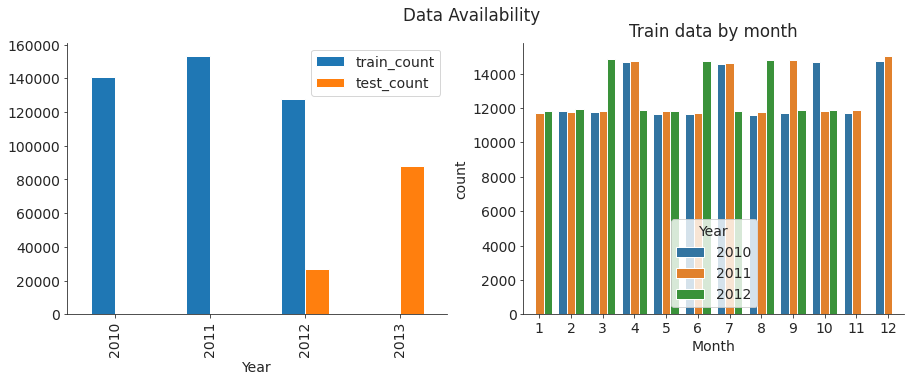

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Data Availability')
data_avail.plot(kind='bar', x='Year', ax= axes[0])
axes[1].set_title("Train data by month")
sns.countplot(data= merged_train_df, x="Month", hue="Year",ax=axes[1] )
sns.despine();

- Train data is available from 5, Feb 2010 to 26 October 2012. 143 weeks of data
- Test data starts from 02, November, 2012 and is available upto 26-July-2013






#### Analysis of Stores by Type and Size

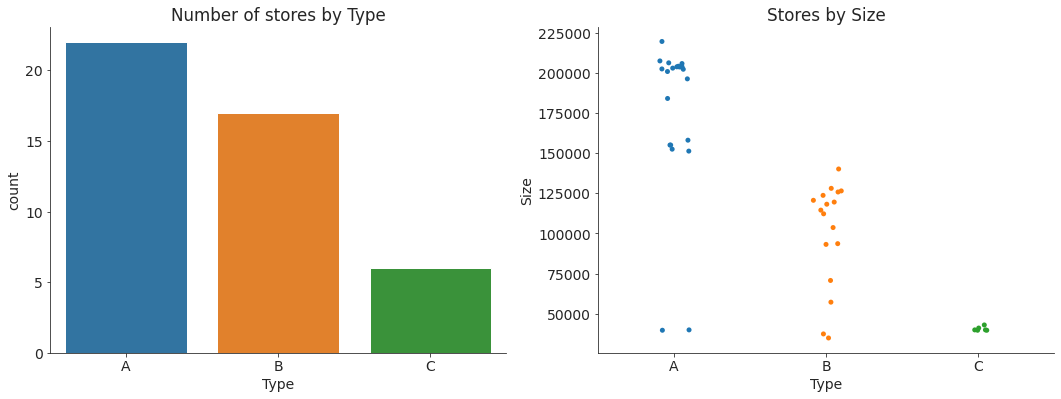

In [ ]:
fig,axes = plt.subplots(1,2,figsize= (18,6))
sns.countplot(data= stores_df,  x = "Type", ax=axes[0])
axes[0].set_title("Number of stores by Type")
sns.stripplot(x="Type", y= "Size", data= stores_df, ax = axes[1])
axes[1].set_title("Stores by Size")
sns.despine();

- Type A stores (Supercenters) are the largest of the three types (with a few exceptions)
- Type C stores (neighbourhood stores) are the smallest in size  
- There are more stores of Type A (22) and very few stores of Type C(6)
- A few Type A (Supercenters) and B (discount stores) also have sizes similar to Type C (neighbourhood) stores

#### Weekly Sales

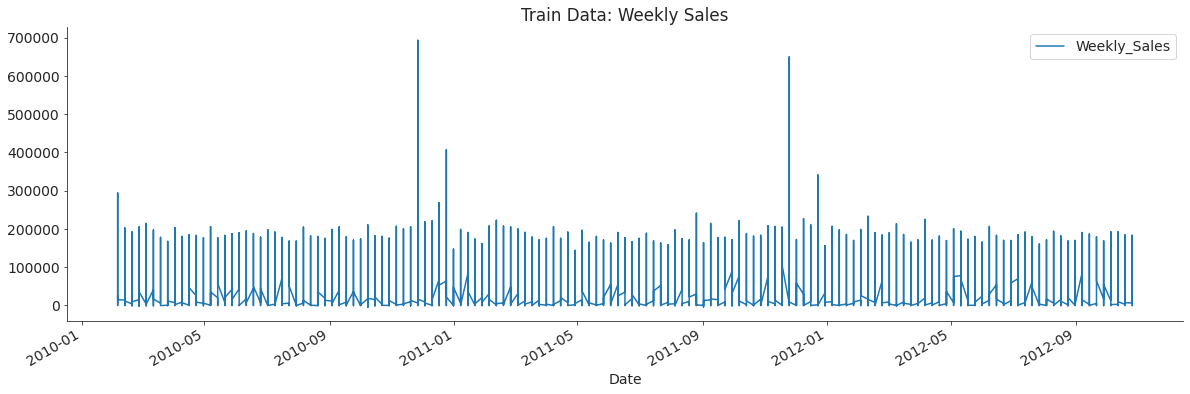

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
merged_train_df.plot(y='Weekly_Sales', x='Date', ax=ax)
plt.title("Train Data: Weekly Sales")
sns.despine();

It is hard to single out trends in this graph. Let us try to smoothen the data to isolate broader trends. Seaborn does this automatically as below.

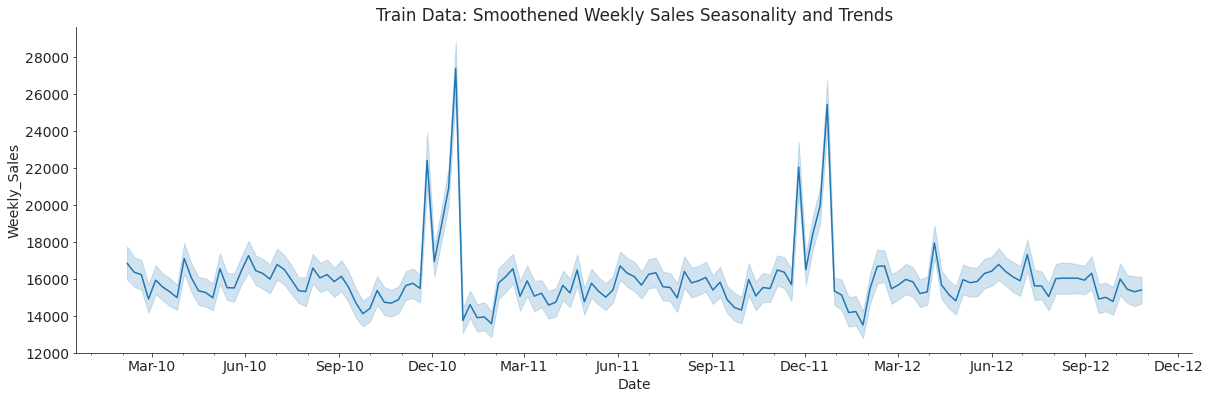

In [ ]:
fig, ax = plt.subplots(figsize = (20,6)) 
sns.lineplot(data=merged_train_df, x="Date", y="Weekly_Sales")
plt.title("Train Data: Smoothened Weekly Sales Seasonality and Trends")

date_format = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
sns.despine();

There seem to be broad trends around Nov-Dec each year. Let us try to isolate some more patterns.

##### Weekly Sales by Month

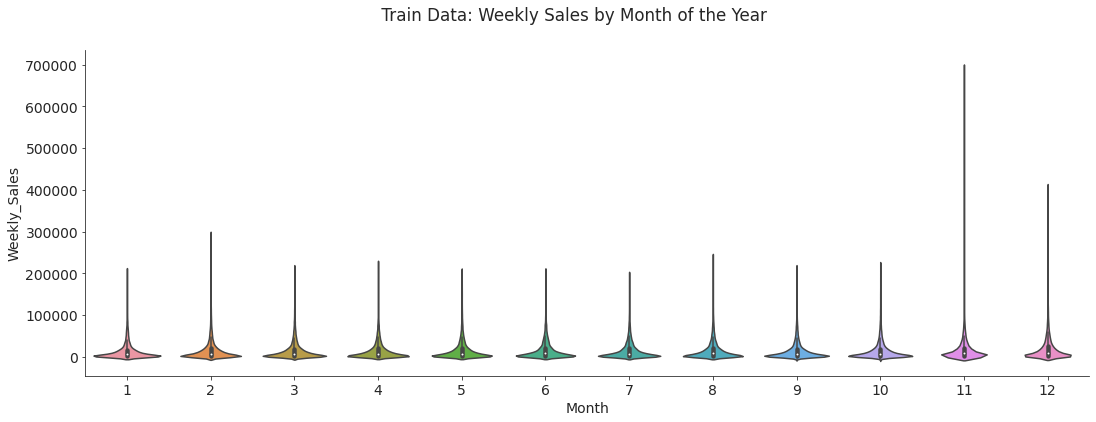

In [ ]:
fig, axes = plt.subplots(figsize = (18,6))
fig.suptitle(" Train Data: Weekly Sales by Month of the Year")
sns.violinplot(data= merged_train_df, y='Weekly_Sales', x = "Month")
sns.despine();

Weekly sales are reported on the Thursday of each week. We see strong seasonality around the same time each year. Let us explore this further

##### Weekly Sales by Week of the Year

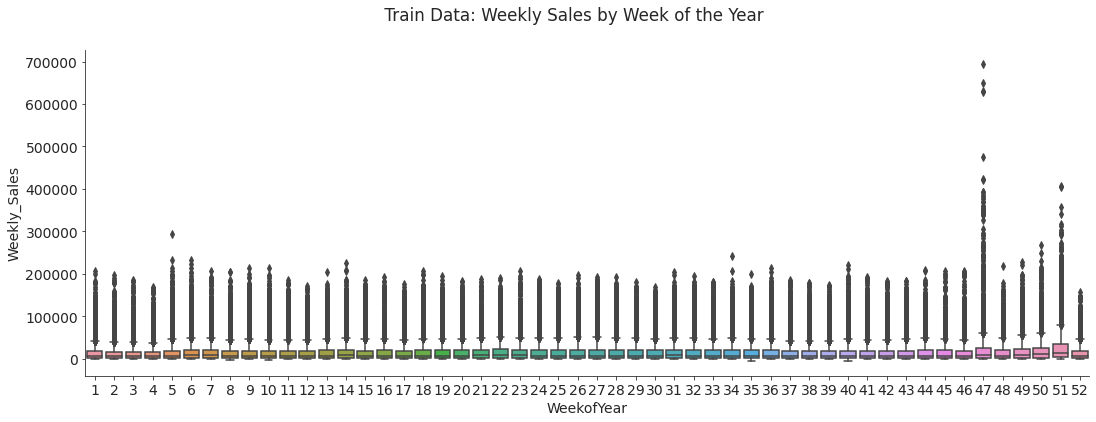

In [ ]:
fig, axes = plt.subplots(figsize = (18,6))
fig.suptitle(" Train Data: Weekly Sales by Week of the Year")
sns.boxplot(data= merged_train_df, y='Weekly_Sales', x = "WeekofYear")
sns.despine();

The highest sales seem to be in the week of 47/48 the ThanksGiving, BlackFriday Week, followed by the Christmas season and the Superbowl holidays.

##### Weekly Sales by Store

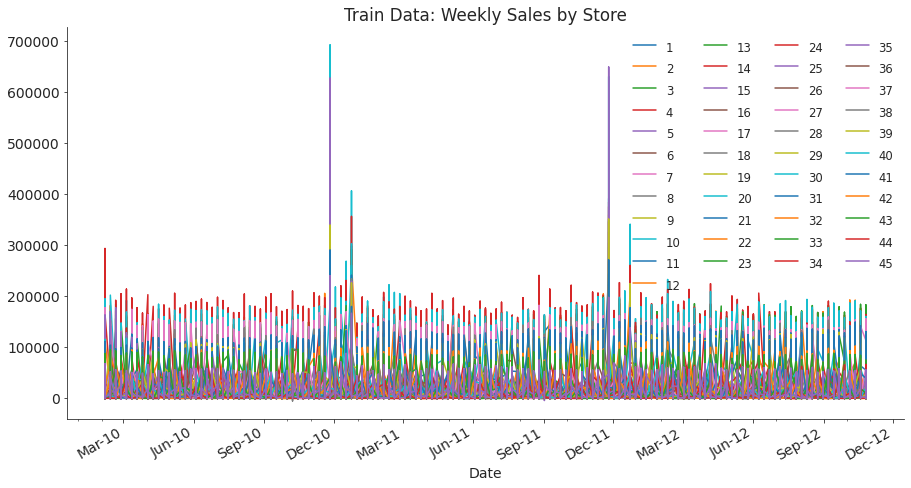

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

grouped = merged_train_df.groupby('Store')
for key, group in grouped:
    group.plot(ax=ax, kind='line', x='Date', y='Weekly_Sales', label=key)

date_format = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

plt.title("Train Data: Weekly Sales by Store")
plt.legend(fontsize='small', ncol=4,handleheight=2.4, labelspacing=0.05, frameon= False)
sns.despine()

Not all stores seem to have the same peaks. Let us now explore departments.

##### Weekly Sales by Dept

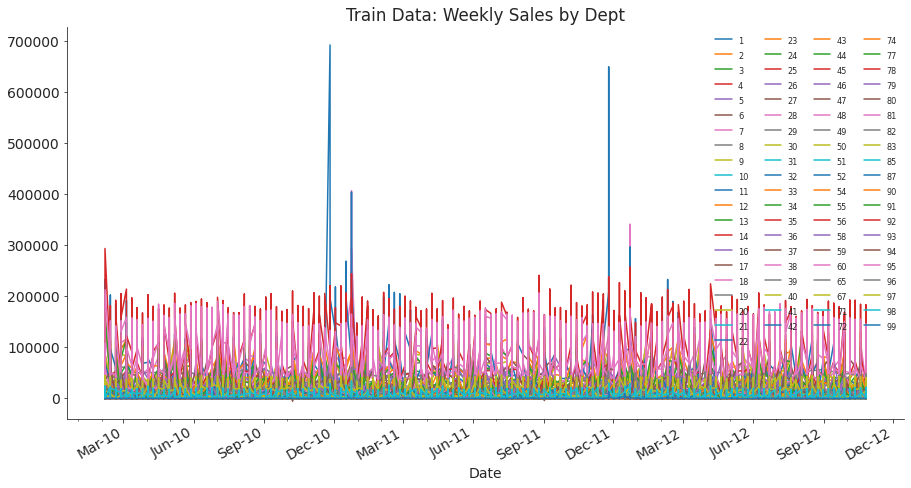

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

grouped = merged_train_df.groupby('Dept')
for key, group in grouped:
    group.plot(ax=ax, kind='line', x='Date', y='Weekly_Sales', label=key)

date_format = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

plt.title("Train Data: Weekly Sales by Dept")
plt.legend(fontsize='xx-small', ncol=4,handleheight=2.4, labelspacing=0.05, frameon= False)
sns.despine()

Individual departments seem to have different patterns too. Let us now see a single store with a couple of departments.

##### Weekly Sales by Select store and Dept

In [ ]:
single_store_dept_mask1 = (merged_train_df.Store == 1) & (merged_train_df.Dept == 1)
single_store_dept_mask2 = (merged_train_df.Store == 1) & (merged_train_df.Dept == 72)

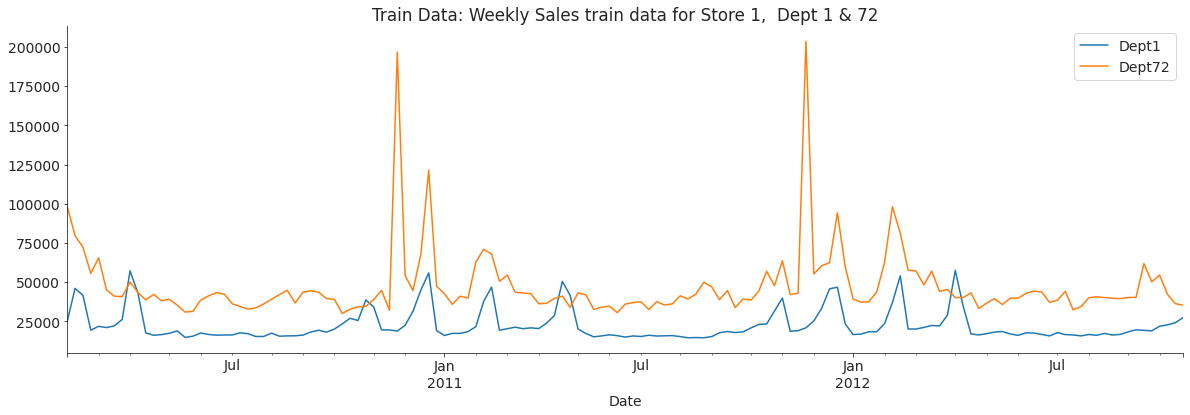

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
merged_train_df[single_store_dept_mask1].plot(y='Weekly_Sales', x='Date',label = 'Dept1', ax=ax)
merged_train_df[single_store_dept_mask2].plot(y='Weekly_Sales', x='Date', label = 'Dept72', ax=ax)
plt.title("Train Data: Weekly Sales train data for Store 1,  Dept 1 & 72")
sns.despine();

Therefore it will be important to retain Store and Department as features.

##### How do holidays effect Weekly Sales?

In [ ]:
fig = px.histogram(train_df, 
                  x='Weekly_Sales', 
                   marginal='box', 
                   color = 'IsHoliday',
                   color_discrete_sequence=['green', 'grey'],
                   nbins = 50,
                   title='Distribution of Weekly Sales by Holiday')
fig.update_layout(bargap=0.1)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

- Weekly sales for weeks with holidays are quite similar to weeks which have no holidays
- But there are definitely some weeks with holidays which see blockbuster sales.
- This is probably because stores run promotions (with markdowns) during certain holidays.
Walmart is famous for its annual mega promos for Black Friday which is the Friday after ThanksGiving.  
Let us now analyse these further.  

![](https://i.imgur.com/4Q12u2a.png)

#### Do larger stores sell more?

In [ ]:
fig = px.histogram(merged_train_df, 
                  x='Weekly_Sales', 
                  marginal='box', 
                  color = 'Type',
                   color_discrete_sequence=['blue','green', 'grey'],
                   nbins = 50,
                  title='Distribution of Weekly Sales by Store Type')
fig.update_layout(bargap=0.1)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

- The larger size stores, Type A have higher Weekly Sales than Type B and C Stores
- However Type B stores have most of the outliers or blockbuster sales. There are most likely the discount stores running holiday promotions with Markdowns(discounts)  
Let us now explore these blockbuster sales further

#### When do the blockbuster sales occur?

In [ ]:
blockbusters = merged_train_df.Weekly_Sales > 220000
blockbusters_df = merged_train_df[blockbusters].sort_values(by='Date', ascending= True)
blockbusters_days = [pd.to_datetime(day).strftime("%Y %B %d") for day in blockbusters_df.Date.unique()]
blockbusters_days

['2010 February 05',
 '2010 November 26',
 '2010 December 10',
 '2010 December 17',
 '2010 December 24',
 '2011 February 11',
 '2011 August 26',
 '2011 October 07',
 '2011 November 25',
 '2011 December 09',
 '2011 December 23',
 '2012 February 10',
 '2012 April 06']

On analysing these further we find the following events:  
'2010 February 05', "SuperBowl-1"  
'2010 November 26', "Black Friday"  
'2010 December 10', "Christmas Season?"  
'2010 December 17',"Christmas Season?"  
'2010 December 24',"Christmas -1"  
'2011 February 11', "Superbowl +5"    
'2011 August 26', "Hurricane Irene"  
'2011 October 07', "Occupy Protests"  
'2011 November 25', "Black Friday"  
'2011 December 09', "Christmas Season?"  
'2011 December 23', "Christmas -2"  
'2012 February 10', "SuperBowl +4"  
'2012 April 06' , 'US Elections Primary"  

- Holidays which have an impact for certain: Week of Super Bowl, Black Friday, Christmas Eve. 
- Possibly Christmas Season from ThanksGiving to Christmas  
- Labour day doesn't seem to figure in this list  
- It's also interesting to see blockbuster sales during the events of Occupy Wall Street protests, Hurricane Irene and the US primaries

#### Which departments sell more and which ones sell the least?

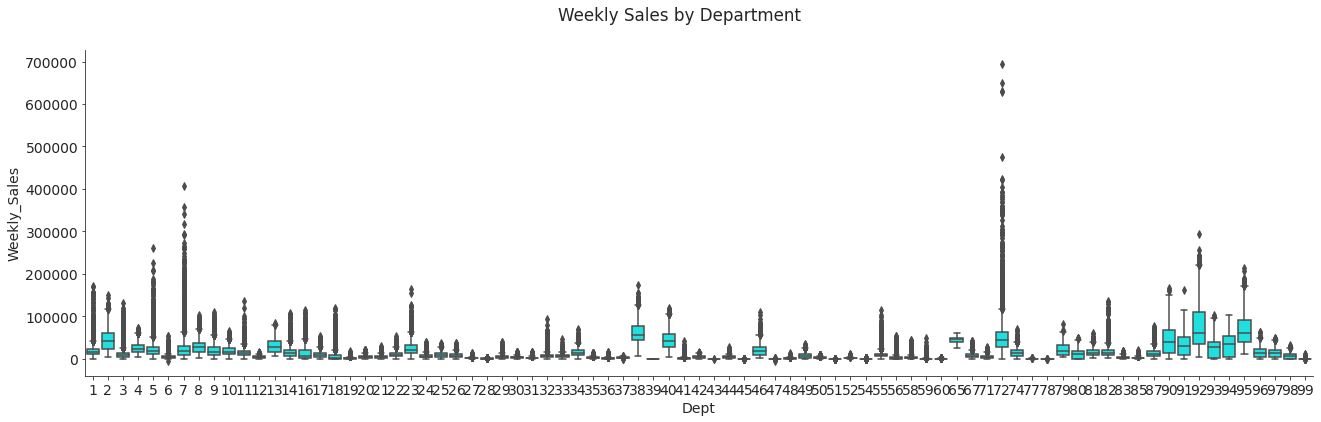

In [ ]:
fig, ax = plt.subplots(figsize = (22,6))
fig.suptitle("Weekly Sales by Department")
sns.boxplot(data= merged_train_df, y='Weekly_Sales', x = 'Dept', color = 'cyan')
sns.despine();

In [ ]:
#Top 10 Departments
depts = merged_train_df.groupby(by=('Dept'), as_index= False)['Weekly_Sales'].mean().sort_values(by=('Weekly_Sales'), ascending= False)
top_10_depts = depts.head(10)
list(top_10_depts.Dept)

[92, 95, 38, 72, 65, 90, 40, 2, 91, 94]

In [ ]:
#Bottom 10 Departments
bottom_10_depts = depts.tail(10)
list(bottom_10_depts.Dept)

[99, 60, 77, 54, 45, 51, 39, 78, 43, 47]

#### Which stores have sold the most and which ones sold the least?

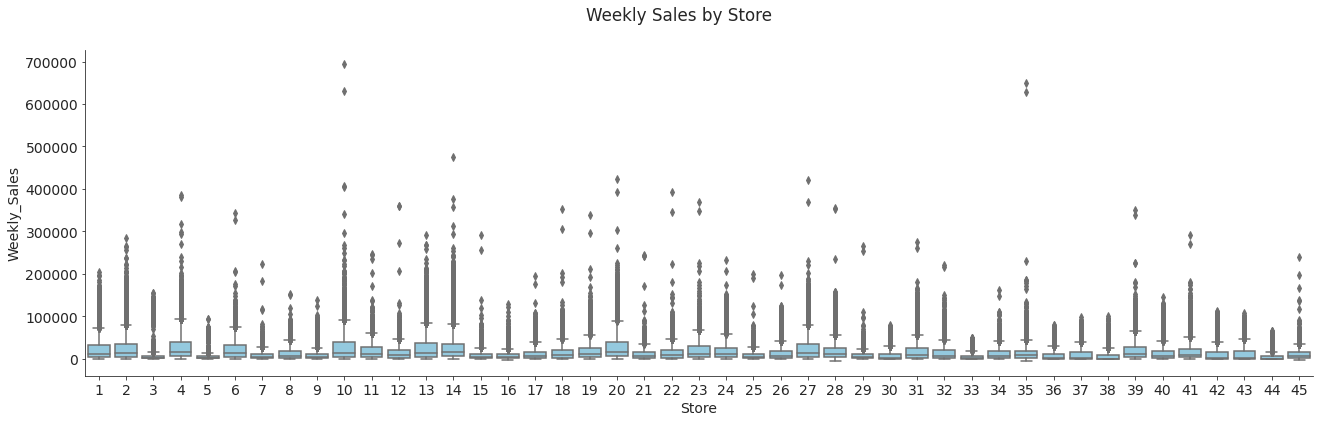

In [ ]:
fig, ax = plt.subplots(figsize = (22,6))
fig.suptitle("Weekly Sales by Store")
sns.boxplot(data= merged_train_df, y='Weekly_Sales', x = "Store", color="skyblue")
sns.despine();

In [ ]:
#Top 10 Stores
stores = merged_train_df.groupby(by=('Store'), as_index= False)['Weekly_Sales'].mean().sort_values(by=('Weekly_Sales'), ascending= False)
top_10_stores = stores.head(10)
list(top_10_stores.Store)

[20, 4, 14, 13, 2, 10, 27, 6, 1, 39]

In [ ]:
#Bottom 10 Stores
bottom_10_stores = stores.tail(10)
list(bottom_10_stores.Store)

[30, 36, 7, 29, 16, 38, 3, 44, 33, 5]

#### How do MarkDowns and Holidays effect Weekly Sales?

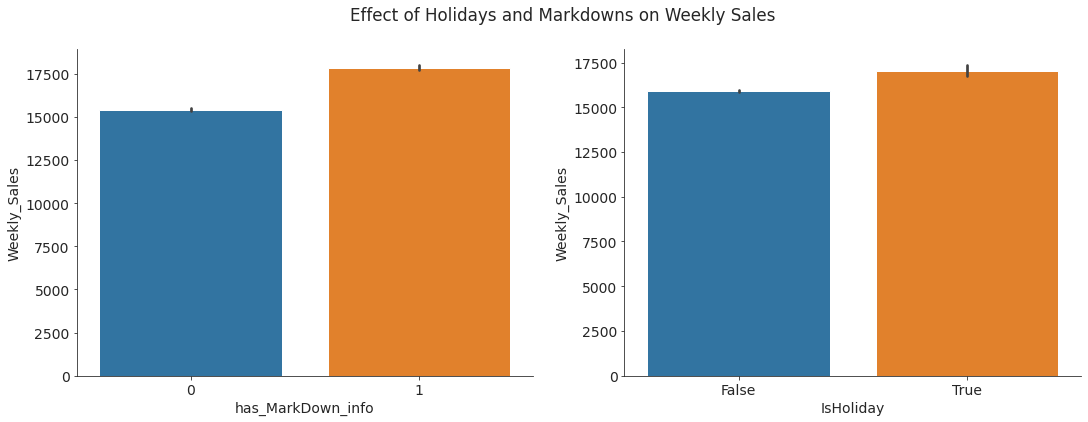

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (18,6))
fig.suptitle("Effect of Holidays and Markdowns on Weekly Sales")
sns.barplot(data= merged_train_df, x="has_MarkDown_info", y="Weekly_Sales", ax= axes[0])
sns.barplot(data=merged_train_df, x="IsHoliday", y="Weekly_Sales",  ax = axes[1])
sns.despine();

Markdowns and Holidays seem to be important as well. But Markdowns are going to be tricky since this information is not present consistently according to the information we have on the competition.

#### What are the trends and distributions of CPI, Unemployment, Fuel Price and Temperature?

In [ ]:
#import matplotlib.dates as mdates

#fig, axes = plt.subplots(1,4, figsize = (18,6))
#fig.suptitle("Trends for external features in the training data")

#chart_features = ['CPI', 'Fuel_Price', 'Unemployment', 'Temperature']
#years = mdates.YearLocator()   # every year,
#months = mdates.MonthLocator((1,4,7,10))  # every quarter
#yearsFmt = mdates.DateFormatter('%b-%Y')


#for i, ax in enumerate(axes):
#    sns.lineplot(data= merged_train_df, x='Date', y=chart_features[i],ax = axes[i])
#    ax.set_title(ax.get_ylabel())
#    ax.xaxis.set_major_locator(months)
#    ax.xaxis.set_major_formatter(yearsFmt)
#    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # need to figure out labels
#sns.despine();

![](https://i.imgur.com/8sxuy2Y.png)

In [ ]:
#fig, axes = plt.subplots(1,4, figsize = (18,6))
#fig.suptitle("Distribution of Fuel Price, CPI,  Unemployment, Temperature")

#for i, ax in enumerate(axes):
#    sns.histplot(data= merged_train_df, x=chart_features[i], hue="IsHoliday", bins= 10, ax= axes[i])

#sns.despine();

![](https://i.imgur.com/aGFkmSx.png)

#### Is the target variable normally distributed? 

In [ ]:
merged_train_df[['Weekly_Sales']].describe().T

,count,mean,std,min,25%,50%,75%,max
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36


**Histogram, boxplot to check if the target variable normally distributed**

In [ ]:
fig = px.histogram(merged_train_df, 
                   x='Weekly_Sales', 
                   marginal='box', 
                   color = 'IsHoliday',
                   color_discrete_sequence=['green', 'grey'],
                   nbins = 100,
                   title='Distribution of Weekly Sales by Holiday')
fig.update_layout(bargap=0.1)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

The histogram, and box plots of Weekly Sales indicate that the data is not normally distributed. We can also confirm this hypothesis using some quantitative statistical tests

**Quantitative tests to check for normal distribution**

In [ ]:
from scipy import stats
from scipy.stats import shapiro,  kstest, kurtosis,  skew
IQR = stats.iqr(merged_train_df.Weekly_Sales, interpolation = 'midpoint')
alpha =  0.05 #Threshold
#skewness 
skew_val = skew(merged_train_df.Weekly_Sales)
#kurtosis
kurt_val = kurtosis(merged_train_df.Weekly_Sales)
#tests for normal distribution - Shapiro Wilk test, Kolmogrov Smirnoff
shapiro_stat, shapiro_p = shapiro(merged_train_df.Weekly_Sales)
ks_stat, ks_p = kstest(merged_train_df.Weekly_Sales, 'norm')
print("Interquartile Range: ", IQR)
print ("Kurtosis: {} \nSkew: {} \n".format(kurt_val, skew_val))
print("Shapiro: Stat = {:.2f}, p = {:.2f}".format(shapiro_stat, shapiro_p))
print("Kolmorgov-Smirnoff: Stat = {:.2f}, p = {:.2f}".format(ks_stat, ks_p))

Interquartile Range:  18126.185
Kurtosis: 21.491020780830272 
Skew: 3.2619965788116954 

Shapiro: Stat = 0.68, p = 0.00
Kolmorgov-Smirnoff: Stat = 0.99, p = 0.00


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



- Mean weekly sales is \\$15,981 . The max value of \\$ 693,099, 75 percentile of \\$ 20,205, the inter-quartile range of \\$18, 126 suggest that there are extreme positive values (outliers)
- The min -\\2,079 and 25 percentile $4,988 indicate that there are negative values but they are far less extreme than the positive outliers.
- Skewness is greater than 1 (highly skewed) and Kurtosis greater than 3 (long right tail and thin peak)
- Shapiro-Wilk is a popular and powerful test to check for normal distribution. As the number of observations greater than 5000, a Kolmogrov Smirnov test can be be used to test whether the distribution resembles a normal disrtibution.It is also a non-parametric test because it does not assume that the distribution is normal unlike Shapiro-Wilk.
- p-values from both tests are less than 0.05 (threshold or alpha) so we can conclude that our observations did not come from a normal distrbution.

Based on the above statistical tests we conclude that our target variable "Weekly Sales" is not normally distributed.  


#### Does the target variable have a linear or non-linear relationship with the input variables?

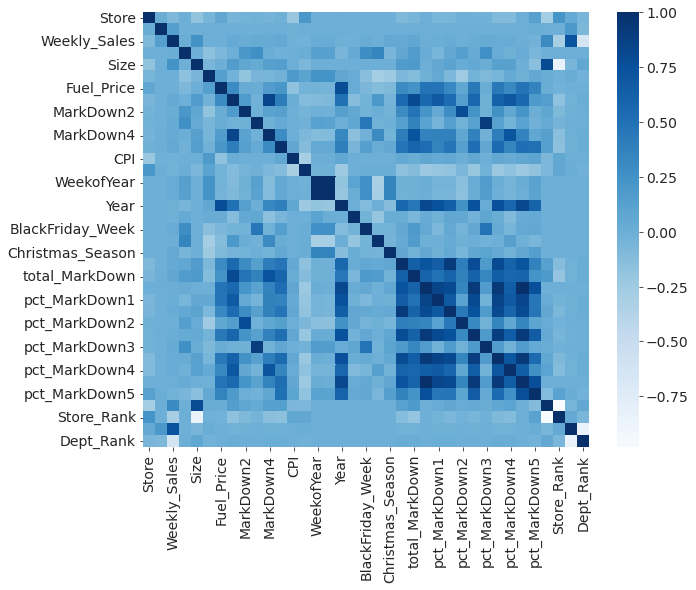

In [ ]:
corr = merged_train_df.corr()
fig, axes = plt.subplots(figsize = (10, 8))
fig = sns.heatmap(corr, cmap = "Blues")

In [ ]:
corr.Weekly_Sales.sort_values(ascending= False)

Weekly_Sales         1.000000
Avg_Dept_Sales       0.732667
Avg_Store_Sales      0.305297
Size                 0.243828
Dept                 0.148032
total_MarkDown       0.065237
Christmas_Season     0.054262
MarkDown5            0.050465
MarkDown1            0.047172
has_MarkDown_info    0.045172
pct_MarkDown3        0.039974
MarkDown3            0.038562
MarkDown4            0.037467
pct_MarkDown4        0.032346
has_MarkDown4        0.031579
Month                0.028409
has_MarkDown2        0.028214
WeekofYear           0.027673
BlackFriday_Week     0.026172
has_MarkDown3        0.023066
MarkDown2            0.020716
IsHoliday            0.012774
pct_MarkDown1        0.010564
has_MarkDown1        0.007692
has_MarkDown5        0.006453
SuperBowl_Week       0.002057
Fuel_Price          -0.000120
pct_MarkDown2       -0.000613
Temperature         -0.002312
Day                 -0.006187
Year                -0.010111
CPI                 -0.020921
pct_MarkDown5       -0.023417
Unemployme

Size seems to have the highest correlation with Weekly Sales, but as seen below, there is no clear linear relationship.

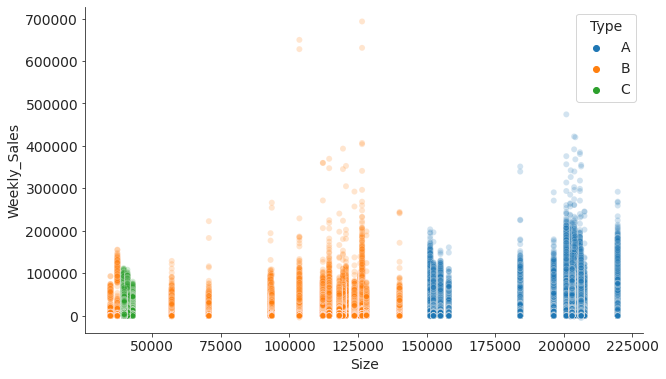

In [ ]:
sns.scatterplot(data = merged_train_df, x='Size', y='Weekly_Sales', hue='Type', alpha = 0.2)
sns.despine();

#### What can we conclude? How does this influence our choice of model?

There are several challenges with this data set.
  - Time series data i.e., data ordered by time
  - Grouped data (Storewise, Deptwise Weekly Sales)
  - Limited training data (number of periods, 143 weeks of training data)
  - Missing data (markdowns, CPI, unemployment)
  - Target variable:
      - Negative sales, 0 sales due to returns or markdowns
      - Target variable is not normally distributed 
      - Target variable seems to have no immediately evident linear relationship with the input variables
      - Extreme positive outliers mostly from strong seasonality during holidays such as SuperBowl, Thanksgiving and Christmas
  - Size and Type are likely to have multicollinearity. We will need to conduct several other tests to check for multi-collinearity, Heteroskedacity, Autocorrelation etc
  
Therefore Linear models are going to perform poorly. Improving the performance of Linear models will require several data transformations given their underlying assumptions.

A tree based regression model is likely to be more effective in predicting Weekly Sales. But a single tree model is unlikely to yield good results.

Our best bets are more powerful and ensemble models such as random forest and boosting models.

Popular apporaches to solving this problem on Kaggle have been
- ARIMA models, Supervised Machine Learning models and very rare neural networks such as LSTM
- Best submissions often use averaging and have several post prediction adjustments for weeks, stores with outliers

Let us now explore some supervised machine learning models to see how they perform. But we will also keep our approach simple to see how these models perform
- Outliers, zero and negative values are not removed
- Minimal transformation for missing values, encoding and scaling
- Feature Selection, Feature Engineering and Hyperparameter tuning to improve our model performance.


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm


'https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm'

# Data preparation

## Train, Val and Test sets

Splitting available data into train, val and test is an important step before training a model on the data and using the model parameters to using the model in the real world for prediction.

- **train** : used to fit our model (get the parameters based on our features)
- **val** : used to tune hyperparameters ( regularise for bias and variance)
- **test**: evaluate model performance close to real world/future

Therefore it is important that the val and test sets are as close to the real world as possible. So experiment with your train_val_test splits.

Key observations to prevent **Data Leakage**
- Split data before transforming data (encoding, imputing, scaling)
- Since this is a time-series dataset , ensure that we order the data by Date and their respective heirarchies Store and Dept before split. Otherwise we will be using data from the future to train our model.
- If using `sklearn` set `shuffle` to `False` using information from the future

In [43]:
#Sort dataset by Dates, Store and Dept
merged_train_df.sort_values(by=['Date','Store','Dept'], inplace= True)

**Separate out numeric and categorical columns**

In [44]:
numeric_cols = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price','CPI', 'Unemployment',
        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',  
        'WeekofYear', 'Month', 'Year', 'Day',]

if holiday_feature:
  numeric_cols = numeric_cols + ['BlackFriday_Week', 'SuperBowl_Week', 'Christmas_Season']

if markdown_feature:
  numeric_cols = numeric_cols + ['total_MarkDown','pct_MarkDown1', 'pct_MarkDown2', 'pct_MarkDown3','pct_MarkDown4', 'pct_MarkDown5']

if performer_feature:
  numeric_cols = numeric_cols + ['Top_Depts', 'Bottom_Depts', 'Top_Stores','Bottom_Stores']

if rank_feature:
  numeric_cols = numeric_cols + ['Store_Rank','Dept_Rank']


ordinal_cols = ['IsHoliday']
nominal_cols = ['Type']
cat_cols = ordinal_cols + nominal_cols

input_cols = numeric_cols + cat_cols
target_col = 'Weekly_Sales'

In [45]:
#Split with shuffle False since this is a TimeSeries data set
from sklearn.model_selection import train_test_split
# 90:10 split
inputs_train_df, inputs_val_df, y_train, y_val = train_test_split(merged_train_df[input_cols], merged_train_df[target_col], test_size = 0.10, random_state = 42, shuffle= False)

#default split
#inputs_train_df, inputs_val_df, y_train, y_val = train_test_split(merged_train_df[input_cols], merged_train_df[target_col], random_state = 42, shuffle= False)

In [46]:
#Split Dates for plots by similar size
#train_size = int(0.70 * len(merged_train_df))
train_size = len(inputs_train_df)
train_dates, val_dates = merged_train_df[:train_size]['Date'], merged_train_df[train_size:]['Date']

In [47]:
print("Split size: ", len(inputs_train_df)/len(train_df), len(inputs_val_df)/len(train_df))

Split size:  0.9 0.1


In [48]:
inputs_test_df = merged_test_df.copy()

In [49]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm


'https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm'

## Encoding, Imputing and Scaling

Let us prepare train, val and test data before we train a model with appropriate transformations.

In [50]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler   

### Encoding

We have several categorical columns in our data. 
- Ordinal columns : From our EDA analysis we know that Type A stores are very large, B in between and C small. We can use this information in our ordinal encoding for Type. Since we have just one column with three distinct values, we used `map` instead of the `OrdinalEncoder`

- Nominal columns: We have tried to one-hot encode the nominal columns Store, Dept etc or considered them as numeric.

- `IsHoliday` is encoded as a int, `1 or 0` to keep the predictive power in a single variable

In [51]:
def encode_data(df):

  if ordinal_enc == True:
    df['IsHoliday'] = df['IsHoliday'] * 1
    store_type_encode = {'A':3, 'B':2,'C':1}
    df['Type_Num'] = df['Type'].map(store_type_encode)
  if onehot_enc == True :  
    df[onehot_enc_cols] = onehot_encoder.transform(df[nominal_cols])

  return df

### Imputing

Markdowns have missing values and so do CPI and Unemployment in the test set. We can replace the `NaNs` for Markdowns with `0` as we have no way of guessing what the Markdown is likely to be.

We used `interpolate` to fill missing values for CPI and Unemployment. We could also use `KNNImputer` or the `pandas ffill or bfill`

In [52]:
def impute_data(df):

  #Replace Nans with zeroes
  cols_MarkDown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
  df[cols_MarkDown] = df[cols_MarkDown].fillna(0)

  if markdown_feature == True:
    markdown_features = ['total_MarkDown', 'pct_MarkDown1', 'pct_MarkDown2', 'pct_MarkDown3','pct_MarkDown4', 'pct_MarkDown5']
    df[markdown_features] = df[markdown_features].fillna(0)

  interpol_cols = ['CPI','Unemployment']
  df[interpol_cols] = df[interpol_cols].interpolate(method ='linear', limit_direction ='forward')
  
  return df

### Scaling

A `MinMax` Scaler is used to transform values in each column in the range of 0 and 1. Encoded columns have been used to handle nominal and ordinal encoded columns, but since `One-hot` and `IsHoliday` are already in the range 0 and 1, they will not be impacted.

In [53]:
def scale_data(df):

  if scaler_on != True:
      minmax_scaler = MinMaxScaler()
      minmax_scaler.fit(inputs_train_df[numeric_cols+encoded_cols])

  df[numeric_cols+encoded_cols] = minmax_scaler.transform(df[numeric_cols+encoded_cols])

  return df

In [54]:
def transform_data(df):

  df = encode_data(df)
  df = impute_data(df)
  #df = scale_data(df)
  
  return df

In [55]:
encoded_cols = []
oridinal_enc_cols = []
onehot_enc_cols = []
global scaler_on
scaler_on = False

if ordinal_enc:
    oridinal_enc_cols = ['Type_Num', 'IsHoliday']
    encoded_cols = encoded_cols + oridinal_enc_cols
else: 
    nominal_cols = nominal_cols + ordinal_cols

if onehot_enc:
    onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_train_df[nominal_cols])
    onehot_enc_cols = list(onehot_encoder.get_feature_names(nominal_cols))
    encoded_cols = encoded_cols + onehot_enc_cols
else:
    encoded_cols = encoded_cols + nominal_cols

In [56]:
inputs_train_df = transform_data(inputs_train_df)
inputs_val_df = transform_data(inputs_val_df)
inputs_test_df = transform_data(inputs_test_df)

In [57]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(inputs_train_df[numeric_cols+encoded_cols])
inputs_train_df[numeric_cols+encoded_cols] = minmax_scaler.transform(inputs_train_df[numeric_cols+encoded_cols])
inputs_val_df[numeric_cols+encoded_cols] = minmax_scaler.transform(inputs_val_df[numeric_cols+encoded_cols])
inputs_test_df[numeric_cols+encoded_cols] = minmax_scaler.transform(inputs_test_df[numeric_cols+encoded_cols])

In [58]:
inputs_train_df.head(2)

,Store,Dept,Size,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,WeekofYear,Month,Year,Day,BlackFriday_Week,SuperBowl_Week,Christmas_Season,total_MarkDown,pct_MarkDown1,pct_MarkDown2,pct_MarkDown3,pct_MarkDown4,pct_MarkDown5,Store_Rank,Dept_Rank,IsHoliday,Type,Type_Num,Type_A,Type_B,Type_C
0,0.0,0.000000,0.630267,0.434149,0.054466,0.85354,0.393611,0.0,0.002536,0.000205,0.0,0.0,0.078431,0.090909,0.0,0.133333,0.0,1.0,0.0,0.0,0.0,0.042306,0.001347,0.0,0.0,0.181818,0.2500,0.0,A,1.0,1.0,0.0,0.0
143,0.0,0.010204,0.630267,0.434149,0.054466,0.85354,0.393611,0.0,0.002536,0.000205,0.0,0.0,0.078431,0.090909,0.0,0.133333,0.0,1.0,0.0,0.0,0.0,0.042306,0.001347,0.0,0.0,0.181818,0.0875,0.0,A,1.0,1.0,0.0,0.0


In [59]:
inputs_val_df.head(2)

,Store,Dept,Size,Temperature,Fuel_Price,CPI,Unemployment,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,WeekofYear,Month,Year,Day,BlackFriday_Week,SuperBowl_Week,Christmas_Season,total_MarkDown,pct_MarkDown1,pct_MarkDown2,pct_MarkDown3,pct_MarkDown4,pct_MarkDown5,Store_Rank,Dept_Rank,IsHoliday,Type,Type_Num,Type_A,Type_B,Type_C
324585,0.75,0.295918,0.667069,0.780431,0.430828,0.046548,0.508792,0.03082,0.003471,0.000248,0.011018,0.022639,0.54902,0.545455,1.0,0.633333,0.0,0.0,0.0,0.037607,0.497447,0.059233,0.002341,0.19754,0.406688,0.545455,0.6750,0.0,A,1.0,1.0,0.0,0.0
324728,0.75,0.306122,0.667069,0.780431,0.430828,0.046548,0.508792,0.03082,0.003471,0.000248,0.011018,0.022639,0.54902,0.545455,1.0,0.633333,0.0,0.0,0.0,0.037607,0.497447,0.059233,0.002341,0.19754,0.406688,0.545455,0.7625,0.0,A,1.0,1.0,0.0,0.0


In [60]:
inputs_test_df.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,WeekofYear,Month,Year,Day,BlackFriday_Week,SuperBowl_Week,Christmas_Season,has_MarkDown_info,total_MarkDown,has_MarkDown1,pct_MarkDown1,has_MarkDown2,pct_MarkDown2,has_MarkDown3,pct_MarkDown3,has_MarkDown4,pct_MarkDown4,has_MarkDown5,pct_MarkDown5,Avg_Store_Sales,Store_Rank,Avg_Dept_Sales,Dept_Rank,Type_Num,Type_A,Type_B,Type_C
0,0.0,0.0,2012-11-02,0.0,A,0.630267,0.561448,0.497821,0.076330,0.051662,0.000564,0.053945,0.025225,0.977673,0.243845,0.843137,0.909091,1.0,0.033333,0.0,0.0,0.0,1,0.114275,1,0.405445,1,0.334905,1,0.004128,1,0.318272,1,0.149126,21711.0,0.181818,19213.0,0.25,1.0,1.0,0.0,0.0
1,0.0,0.0,2012-11-09,0.0,A,0.630267,0.619374,0.458606,0.128841,0.034706,0.000490,0.068867,0.056710,0.977859,0.243845,0.862745,0.909091,1.0,0.266667,0.0,0.0,0.0,1,0.159699,1,0.489705,1,0.179410,1,0.002924,1,0.290743,1,0.239898,21711.0,0.181818,19213.0,0.25,1.0,1.0,0.0,0.0


# Feature Selection

We may have several input features or variables, but selecting fewer and right input variables will make a huge difference in the predictive power or model outcome. Choosing many variables will lead to complex models with low predictive power and several problems such as
- Increased noise(variables that don't have any explanatory or predictive power)
- Increased dimensionality ( many features which are difficult to interpret and thinly distributed predictive power)
- Underfitting and overfitting

There are many feature selection techniques such as PCA, SVD, autoencoders and Lasso too. We will make some intuition based selection for now and chalk this up for future work.

In [61]:
print(numeric_cols + encoded_cols)

['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'WeekofYear', 'Month', 'Year', 'Day', 'BlackFriday_Week', 'SuperBowl_Week', 'Christmas_Season', 'total_MarkDown', 'pct_MarkDown1', 'pct_MarkDown2', 'pct_MarkDown3', 'pct_MarkDown4', 'pct_MarkDown5', 'Store_Rank', 'Dept_Rank', 'Type_Num', 'IsHoliday', 'Type_A', 'Type_B', 'Type_C']


In [82]:
simple_input_cols = ['Store_Rank', 'Dept_Rank','Size', 'IsHoliday','Type_A', 'Type_B', 'Type_C', 'WeekofYear','Year','Month', 'Day']

select_encoded_cols = encoded_cols
#select_encoded_cols = select_encoded_cols.remove('Type_Num')
select_numeric_cols = numeric_cols
#select_numeric_cols = select_numeric_cols.remove(['BlackFriday_Week', 'SuperBowl_Week', 'Christmas_Season', 'total_MarkDown', 'pct_MarkDown1', 'pct_MarkDown2', 'pct_MarkDown3', 'pct_MarkDown4', 'pct_MarkDown5', 'Store_Rank', 'Dept_Rank'])

#select_input_cols = select_numeric_cols + select_encoded_cols
select_input_cols = ['Store_Rank', 'Dept_Rank','Size', 'Type_A', 'Type_B', 'Type_C','IsHoliday', 'WeekofYear','Month','Day','Year',
                     'BlackFriday_Week', 'SuperBowl_Week', 'Christmas_Season','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                     'Fuel_Price', 'CPI', 'Unemployment','Temperature']

if simple_model:
  input_cols = simple_input_cols
else:
  input_cols = select_input_cols

X_train = inputs_train_df[input_cols].copy()
X_val = inputs_val_df[input_cols].copy()
X_test = inputs_test_df[input_cols].copy()


In [83]:
X_train.columns

Index(['Store_Rank', 'Dept_Rank', 'Size', 'Type_A', 'Type_B', 'Type_C',
       'IsHoliday', 'WeekofYear', 'Month', 'Day', 'Year', 'BlackFriday_Week',
       'SuperBowl_Week', 'Christmas_Season', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'Fuel_Price', 'CPI',
       'Unemployment', 'Temperature'],
      dtype='object')

In [84]:
X_train.sample(5)

,Store_Rank,Dept_Rank,Size,Type_A,Type_B,Type_C,IsHoliday,WeekofYear,Month,Day,Year,BlackFriday_Week,SuperBowl_Week,Christmas_Season,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Fuel_Price,CPI,Unemployment,Temperature
253587,0.477273,0.6875,0.636752,1.0,0.0,0.0,0.0,0.196078,0.181818,0.500000,1.0,0.0,0.0,0.0,0.078707,0.004073,0.000234,0.022752,0.019209,0.759804,0.115640,0.331184,0.363209
133843,0.045455,0.2375,0.898651,1.0,0.0,0.0,0.0,0.980392,1.000000,0.766667,0.0,0.0,0.0,1.0,0.000000,0.002536,0.000205,0.000000,0.000000,0.364379,0.566943,0.453986,0.319472
197402,0.000000,0.5375,0.914045,1.0,0.0,0.0,0.0,0.862745,0.909091,0.366667,0.0,0.0,0.0,0.0,0.000000,0.002536,0.000205,0.000000,0.000000,0.250000,0.794453,0.332845,0.434834
205622,0.681818,0.7125,0.569925,0.0,1.0,0.0,0.0,0.117647,0.090909,0.600000,0.0,0.0,0.0,0.0,0.000000,0.002536,0.000205,0.000000,0.000000,0.022876,0.852023,0.414908,0.409100
170660,0.409091,0.4625,0.464300,0.0,1.0,0.0,0.0,0.235294,0.272727,0.000000,0.5,0.0,0.0,0.0,0.000000,0.002536,0.000205,0.000000,0.000000,0.635076,0.080345,0.478507,0.363209


# Evaluation Metrics

A function to compute Weighted Mean Absolute error(WMAE) as required by the competition is defined. A function to evaluate based on other metrics is also added.

In [65]:
def weighted_mean_absolute_error(df, y_actuals, y_preds):

  if 'IsHoliday' in df.columns:
    weights = df['IsHoliday'].apply(lambda x: 5 if x ==1 else 1)
  elif 'IsHoliday_1' in df.columns:
    weights = df['IsHoliday_1'].apply(lambda x: 5 if x==1 else 1)

  wmae = (np.sum(abs(y_actuals-y_preds)*weights))/np.sum(weights)

  return wmae

In [66]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def model_eval(df, y_actuals, y_preds):
    
    wmae = round(weighted_mean_absolute_error(df, y_actuals, y_preds),2)
    mae = round(mean_absolute_error(y_actuals, y_preds),2)
    rmse = round(mean_squared_error(y_actuals, y_preds, squared= False),2)
    r2 = round(r2_score(y_actuals, y_preds),2)

    n = len(df)
    p = len(df.columns)
    adj_r2 = round(1-(1-r2)*(n-1)/(n-p-1),2)
    
    return {'wmae': wmae, 
            'mae': mae,
            'rmse': rmse,
            'adj_r2': adj_r2,
            'r2': r2
            }

# Baseline Model

Let's create a simple baseline model to evaluate our models. Here we will use a grouped average, average sales by each store and dept during a month.

In [67]:
train_preds_grouped_mean = merged_train_df.groupby(['Store','Dept','Month']).Weekly_Sales.transform('mean')
model_eval(merged_train_df, merged_train_df.Weekly_Sales, train_preds_grouped_mean)

{'adj_r2': 0.95, 'mae': 1814.99, 'r2': 0.95, 'rmse': 5114.45, 'wmae': 2120.38}

Any model we train from now on should give us a better training score than the WMAE of 2120.

# Model Selection

In [68]:
!pip install xgboost lightgbm --upgrade --quiet

In [69]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [71]:
def try_model(model, plot):
    # Fit the model
    model.fit(X_train, y_train)
 
    # Generate predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Compute Errors or loss
    train_error = model_eval(X_train, y_train, train_preds)
    val_error = model_eval(X_val, y_val, val_preds)

    if plot:
      plot_preds(train_preds, val_preds,type(model).__name__) 

    return train_error, val_error

In [72]:
def plot_importance(features, importance, model_name):

  importance_df = pd.DataFrame({
                              'features': features,
                              'importance': importance
                              }).sort_values(by = 'importance', ascending= False)
  plt.figure(figsize=(10,6))
  plt.title(model_name + ' Feature Importance')
  sns.barplot(data=importance_df.head(10), x='importance', y='features')
  sns.despine();

  return

In [73]:
def plot_preds(train_preds, val_preds, model_name ):

  sns.lineplot( x= train_dates, y= y_train)
  sns.lineplot( x= val_dates, y= y_val)
  sns.lineplot( x= train_dates, y= train_preds)
  sns.lineplot( x= val_dates, y= val_preds)

  plt.xlabel('Date')
  plt.ylabel('Weekly Sales')
  plt.legend(['Actual-Train','Actual-Val','Prediction-Train','Prediction-val'])
  plt.title("{}".format(model_name))
  sns.despine();

  return

## Plain Vanilla Models

#### Linear Regression

Train error(s):
 {'wmae': 10420.91, 'mae': 10204.94, 'rmse': 16055.39, 'adj_r2': 0.5, 'r2': 0.5} 
 Val Error(s):
 {'wmae': 10237.34, 'mae': 10095.62, 'rmse': 14979.98, 'adj_r2': 0.53, 'r2': 0.53}


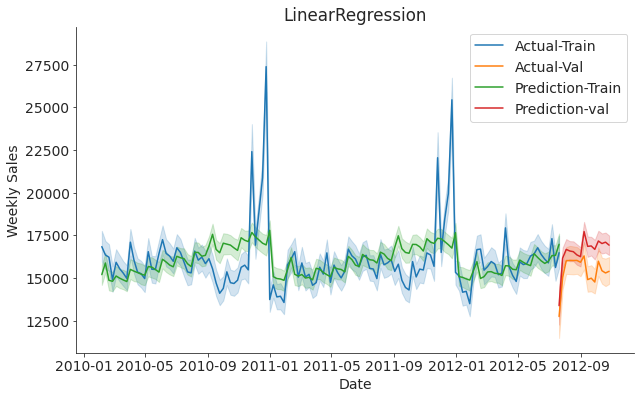

In [ ]:
model = LinearRegression()
train_error, val_error = try_model(model, plot= True)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Intercept:  -7.389133305437968e+16


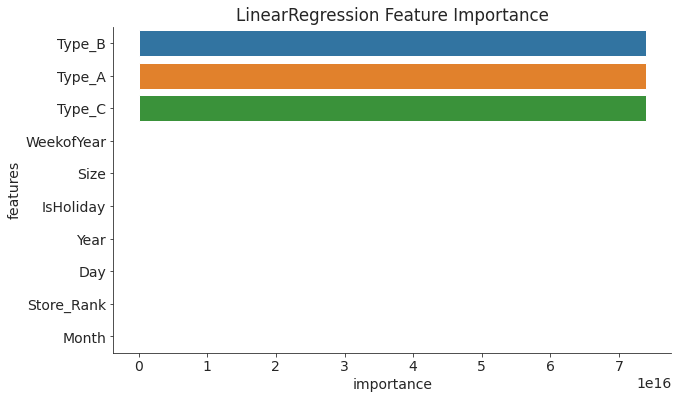

In [ ]:
model_name =  type(model).__name__
plot_importance(X_train.columns, model.coef_, model_name)
print("Intercept: ",model.intercept_)

As we had guessed,  the Linear Regression model has performed poorly and is underfitting the data.

Therefore this model has high bias (large RMSE, MAE, WMAE: measures of difference between predicted target values and actual target values) using the current input features.  Since the loss or errors on the train and val set is close we could say that the model has low variance.

We can improve the performance by
- regularisation using lasso(l1) or ridge(r2) regularisation etc.
- choosing a more powerful model

#### SGD Regression

Train error(s):
 {'wmae': 10374.97, 'mae': 10151.12, 'rmse': 16059.21, 'adj_r2': 0.5, 'r2': 0.5} 
 Val Error(s):
 {'wmae': 10133.17, 'mae': 9980.05, 'rmse': 14949.11, 'adj_r2': 0.53, 'r2': 0.53}


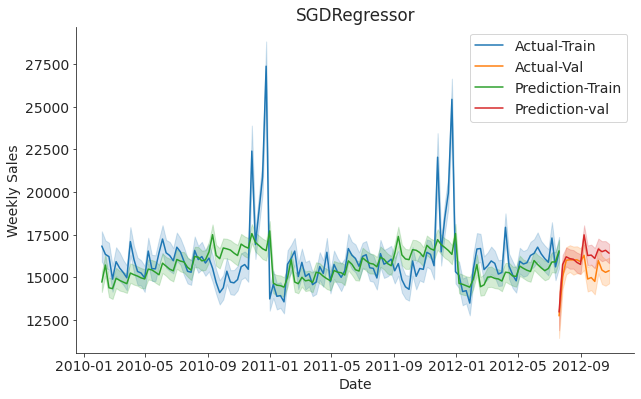

In [ ]:
model = SGDRegressor(random_state = 42, max_iter = 10000)
train_error, val_error = try_model(model, plot= True)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

### Decision Tree

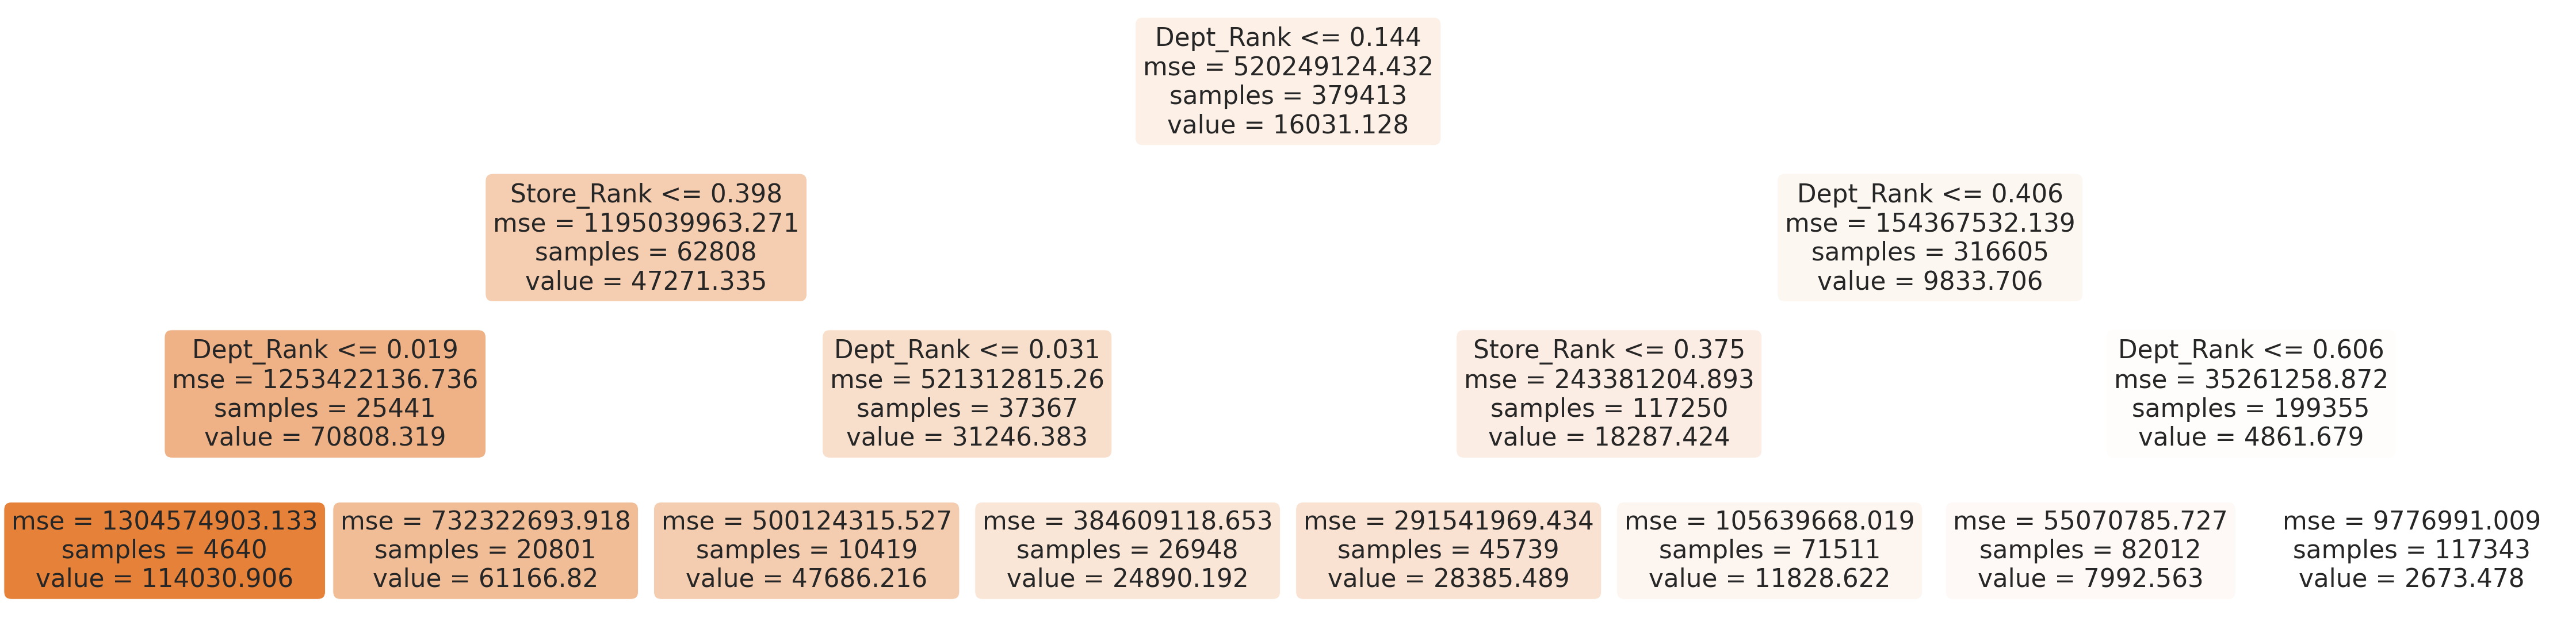

In [ ]:
tree = DecisionTreeRegressor(random_state=42, max_depth= 3)
tree.fit(X_train, y_train)
plt.figure(figsize=(80,20))
plot_tree(tree, feature_names=X_train.columns, filled=True, rounded=True);

In [ ]:
%%time
model = DecisionTreeRegressor(random_state=42)
train_error, val_error = try_model(model, plot= False)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 102.15, 'mae': 101.3, 'rmse': 865.52, 'adj_r2': 1.0, 'r2': 1.0} 
 Val Error(s):
 {'wmae': 1639.81, 'mae': 1604.7, 'rmse': 3308.62, 'adj_r2': 0.98, 'r2': 0.98}
CPU times: user 2.58 s, sys: 38.1 ms, total: 2.62 s
Wall time: 2.63 s


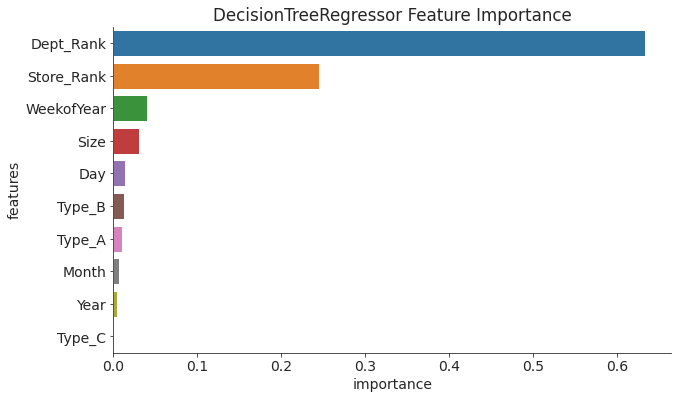

In [ ]:
model_name =  type(tree).__name__
plot_importance(X_train.columns,model.feature_importances_, model_name)

### Ensemble Models

#### Random Forest

In [ ]:
%%time
model = RandomForestRegressor(random_state = 42, n_jobs = -1)
train_error, val_error = try_model(model, plot= False)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 590.6, 'mae': 545.28, 'rmse': 1367.6, 'adj_r2': 1.0, 'r2': 1.0} 
 Val Error(s):
 {'wmae': 1352.19, 'mae': 1333.44, 'rmse': 2728.56, 'adj_r2': 0.98, 'r2': 0.98}
CPU times: user 4min, sys: 1.21 s, total: 4min 1s
Wall time: 2min 3s


In [ ]:
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# Methods to get depth of trees in the forest - est.get_depth(), est.tree_.max_depth, est.max_depth

In [ ]:
max_depth_by_tree = [est.get_depth() for est in model.estimators_]
print( "average depth of trees: {}, number of trees: {}".format(np.mean(max_depth_by_tree), len(max_depth_by_tree)))

average depth of trees: 39.04, number of trees: 100


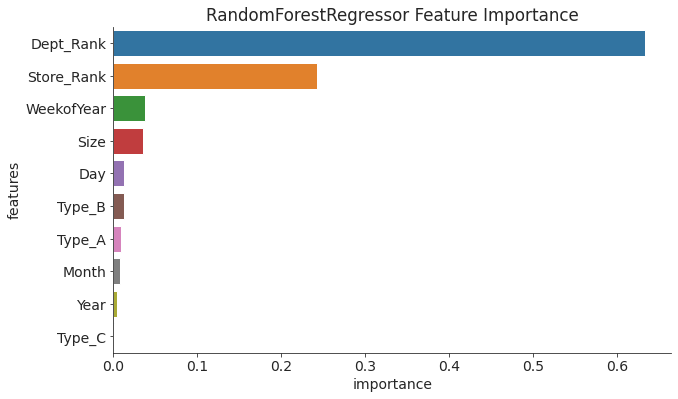

In [ ]:
model_name =  type(model).__name__
plot_importance(X_train.columns,model.feature_importances_, model_name)

#### XGBoost

In [ ]:
%%time
model = XGBRegressor(random_state = 42, n_jobs = -1)
train_error, val_error = try_model(model, plot= False)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 2868.7, 'mae': 2722.64, 'rmse': 4766.46, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2872.86, 'mae': 2776.58, 'rmse': 4724.35, 'adj_r2': 0.95, 'r2': 0.95}
CPU times: user 45.2 s, sys: 164 ms, total: 45.4 s
Wall time: 23.5 s


In [ ]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

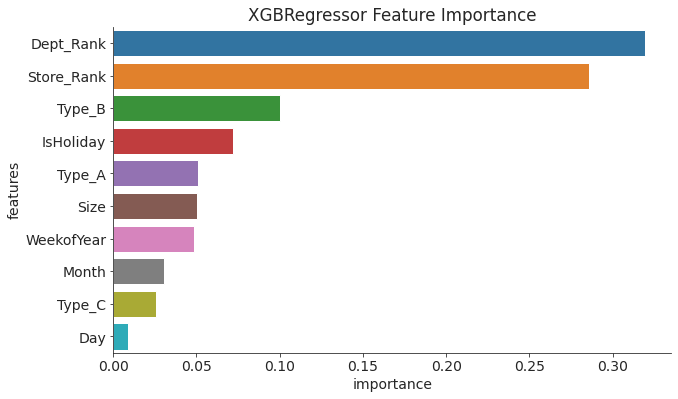

In [ ]:
model_name =  type(model).__name__
plot_importance(X_train.columns,model.feature_importances_, model_name)

#### Light GBM

In [ ]:
%%time

lgbm = LGBMRegressor(random_state = 42, n_jobs= -1)
lgbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        early_stopping_rounds=1000
        )
train_preds = lgbm.predict(X_train)
val_preds = lgbm.predict(X_val)

[1]	valid_0's l2: 4.00022e+08
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l2: 3.38566e+08
[3]	valid_0's l2: 2.88993e+08
[4]	valid_0's l2: 2.49075e+08
[5]	valid_0's l2: 2.14839e+08
[6]	valid_0's l2: 1.87363e+08
[7]	valid_0's l2: 1.64367e+08
[8]	valid_0's l2: 1.45783e+08
[9]	valid_0's l2: 1.30797e+08
[10]	valid_0's l2: 1.18277e+08
[11]	valid_0's l2: 1.08438e+08
[12]	valid_0's l2: 9.99895e+07
[13]	valid_0's l2: 9.29104e+07
[14]	valid_0's l2: 8.74661e+07
[15]	valid_0's l2: 8.28275e+07
[16]	valid_0's l2: 7.9041e+07
[17]	valid_0's l2: 7.56007e+07
[18]	valid_0's l2: 7.15651e+07
[19]	valid_0's l2: 6.86857e+07
[20]	valid_0's l2: 6.59094e+07
[21]	valid_0's l2: 6.3445e+07
[22]	valid_0's l2: 6.18333e+07
[23]	valid_0's l2: 6.01786e+07
[24]	valid_0's l2: 5.84411e+07
[25]	valid_0's l2: 5.73385e+07
[26]	valid_0's l2: 5.58259e+07
[27]	valid_0's l2: 5.49585e+07
[28]	valid_0's l2: 5.4477e+07
[29]	valid_0's l2: 5.40447e+07
[30]	valid_0's l2: 5.33004e+07
[31]	valid_0's l2: 

In [ ]:
model_eval(X_train, y_train, train_preds)

{'adj_r2': 0.92, 'mae': 3773.61, 'r2': 0.92, 'rmse': 6324.53, 'wmae': 3895.78}

In [ ]:
model_eval(X_val, y_val, val_preds)

{'adj_r2': 0.92, 'mae': 3728.09, 'r2': 0.92, 'rmse': 6163.63, 'wmae': 3822.23}

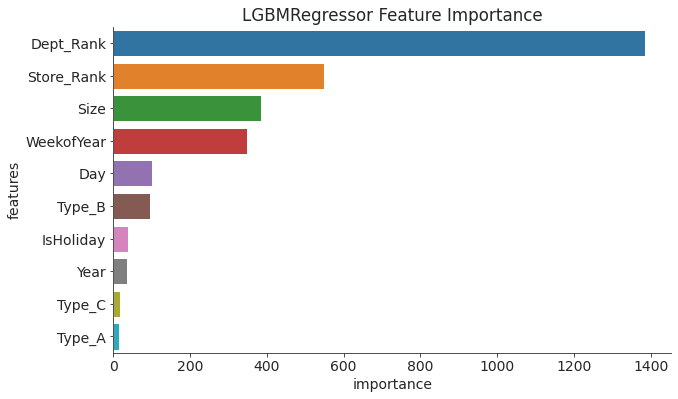

In [ ]:
model_name =  type(lgbm).__name__
plot_importance(X_train.columns,lgbm.feature_importances_, model_name)

###Conclusion from Model Selection

Our best model is the Random forest for the simple_input_cols `'Store_Rank', 'Dept_Rank','Size', 'IsHoliday','Type_A', 'Type_B', 'Type_C', 'WeekofYear','Year','Month', 'Day'` with a validation loss of \\$1,352.    
This gets us to a Kaggle score of 2,904 (Top 13% of the public leaderboard)

![](https://i.imgur.com/YbKIlpE.png)

In [77]:
rf_hyper_params = {
    'n_estimators': 200,
    'max_depth': 40,
    'max_features': 0.9
}

In [78]:
rf = RandomForestRegressor(random_state = 42, n_jobs = -1,**rf_hyper_params )

In [79]:
model = rf
train_error, val_error = try_model(model, plot= False)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 585.91, 'mae': 540.19, 'rmse': 1357.92, 'adj_r2': 1.0, 'r2': 1.0} 
 Val Error(s):
 {'wmae': 1335.02, 'mae': 1316.03, 'rmse': 2682.9, 'adj_r2': 0.98, 'r2': 0.98}


In [ ]:
#model = RandomForestRegressor(random_state = 42, n_jobs = -1, n_estimators= 200, 
#                              max_depth= 40, max_features= 0.9)

# HyperParameter Tuning

Select the best model and tune model hyperparameters. Our best model is the Random Forest, but we select XGB mainly for the speed and GPU in XGBoost to run experiements. 

We can try different combinations of hyperpramateres using `RandomSearchCV` or other optimisation mehods. However we will need a GPU given the size of data. Both didn't complete given the size of the dataset and GPU restrictions. So the tuning was done by hand using trial and error.

Let us now try training a model with an expanded feature set inlcuding holidays, markdowns and external features such as   
`'Store_Rank', 'Dept_Rank','Size', 'Type_A', 'Type_B', 'Type_C','IsHoliday', 'WeekofYear','Month','Day',
'Year','BlackFriday_Week', 'SuperBowl_Week', 'Christmas_Season',  
'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
'Fuel_Price', 'CPI', 'Unemployment','Temperature'`

## XGBoost

**What are some of the key hyperparameters for XGBoost?**

We tune the following to reduce overfitting. If underfitting is an issue, then these can be increased.
-  Number of levels `max_depth`
-  Number of trees `n_estimators`
- `learning_rate` low learning rates to reduce overfitting
-  Sample features `colsample_bytree`, sample observations/rows `subsample`: Number or fraction to increase randomness
- `gamma`, `reg_lambda`, `reg_alpha` : for  regularisation parameter but couldn't find values for gamma that made a difference.

Note: Use GPU by setting `tree_method = 'gpu_hist'`


In [ ]:
use_GPU = True

In [ ]:
def test_hyperparams(**hyper_params):

    if use_GPU:
    #With GPU
        model = XGBRegressor(random_state = 42, n_jobs = -1, tree_method = 'gpu_hist', **hyper_params)
    else:
    #without GPU
        model = XGBRegressor(random_state = 42, n_jobs = -1,**hyper_params)

    train_error, val_error = try_model(model, plot= False)
    print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

    return train_error, val_error

In [ ]:
def plot_learning_curve(hyper_param_name, hyper_param_values, train_errors, val_errors ):
    plt.plot(hyper_param_values, train_errors, 'b-o', label='Training error')
    plt.plot(hyper_param_values, val_errors, 'r-o', label='Validation error')
    plt.xlabel(hyper_param_name)   
    plt.ylabel('WMAE')
    plt.title('Hyperparameter Tuning : ' + hyper_param_name, pad=15, size=15)
    plt.legend(frameon= False)
    sns.despine()

    return

Let us now train our XGB model for the extended set of input features without tuning any hyperparamters.

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


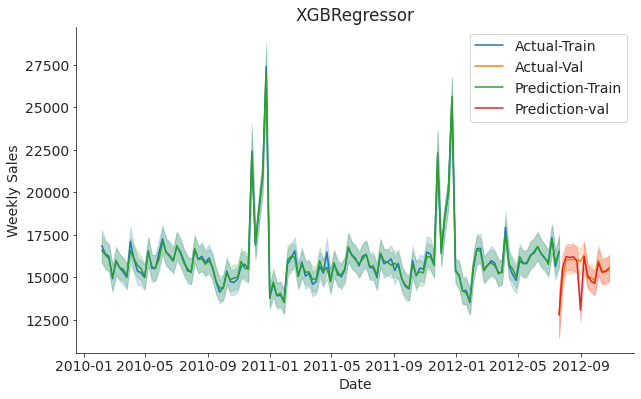

In [ ]:
if use_GPU:
  #With GPU
  xgb = XGBRegressor(random_state = 42, n_jobs = -1, tree_method = 'gpu_hist')
else:
  #without GPU
  xgb = XGBRegressor(random_state = 42, n_jobs = -1)

model = xgb
train_error, val_error = try_model(model, plot= True)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

######max_depth

In [ ]:
exp_train_errors, exp_val_errors = [], []

In [ ]:
train_error, val_error = test_hyperparams(max_depth = 3)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 5039.75, 'mae': 4782.21, 'rmse': 8755.86, 'adj_r2': 0.85, 'r2': 0.85} 
 Val Error(s):
 {'wmae': 4666.74, 'mae': 4577.91, 'rmse': 7691.91, 'adj_r2': 0.88, 'r2': 0.88}


In [ ]:
train_error, val_error = test_hyperparams(max_depth = 10)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 1241.92, 'mae': 1220.49, 'rmse': 2093.06, 'adj_r2': 0.99, 'r2': 0.99} 
 Val Error(s):
 {'wmae': 2047.43, 'mae': 1978.17, 'rmse': 3637.28, 'adj_r2': 0.97, 'r2': 0.97}


In [ ]:
train_error, val_error = test_hyperparams(max_depth = 15)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 354.94, 'mae': 367.94, 'rmse': 963.95, 'adj_r2': 1.0, 'r2': 1.0} 
 Val Error(s):
 {'wmae': 1686.86, 'mae': 1653.62, 'rmse': 3141.76, 'adj_r2': 0.98, 'r2': 0.98}


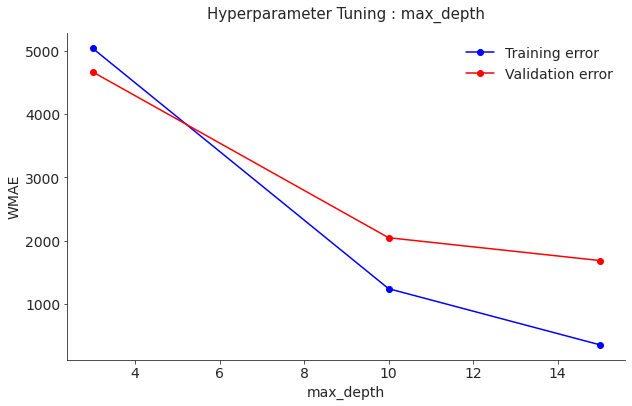

In [ ]:
hyper_param_name = 'max_depth'
hyper_param_values = [3,10,15]        
plot_learning_curve(hyper_param_name,hyper_param_values,exp_train_errors,exp_val_errors)

######n_estimators

In [ ]:
exp_train_errors, exp_val_errors = [], []

In [ ]:
train_error, val_error = test_hyperparams(n_estimators = 50)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])


Train error(s):
 {'wmae': 3515.68, 'mae': 3371.18, 'rmse': 5869.41, 'adj_r2': 0.93, 'r2': 0.93} 
 Val Error(s):
 {'wmae': 3492.17, 'mae': 3424.85, 'rmse': 5766.08, 'adj_r2': 0.93, 'r2': 0.93}


In [ ]:
train_error, val_error = test_hyperparams(n_estimators = 100)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(n_estimators = 100)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(n_estimators = 1000)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 1403.19, 'mae': 1358.78, 'rmse': 2351.25, 'adj_r2': 0.99, 'r2': 0.99} 
 Val Error(s):
 {'wmae': 2174.48, 'mae': 2115.42, 'rmse': 3746.17, 'adj_r2': 0.97, 'r2': 0.97}


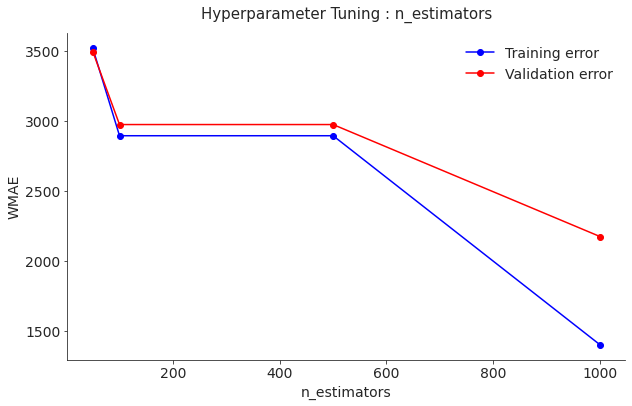

In [ ]:
hyper_param_name = 'n_estimators'
hyper_param_values = [50, 100, 500, 1000]          
plot_learning_curve(hyper_param_name,hyper_param_values,exp_train_errors,exp_val_errors)

######subsample

In [ ]:
exp_train_errors, exp_val_errors = [], []

In [ ]:
train_error, val_error = test_hyperparams(subsample = 0.5)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2986.16, 'mae': 2874.81, 'rmse': 4965.74, 'adj_r2': 0.95, 'r2': 0.95} 
 Val Error(s):
 {'wmae': 3169.35, 'mae': 3098.88, 'rmse': 5328.55, 'adj_r2': 0.94, 'r2': 0.94}


In [ ]:
train_error, val_error = test_hyperparams(subsample = 0.8)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2941.19, 'mae': 2840.63, 'rmse': 4859.26, 'adj_r2': 0.95, 'r2': 0.95} 
 Val Error(s):
 {'wmae': 3042.85, 'mae': 2956.42, 'rmse': 4976.47, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(subsample = 0.9)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2898.64, 'mae': 2779.79, 'rmse': 4788.09, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 3029.86, 'mae': 2959.52, 'rmse': 4965.88, 'adj_r2': 0.95, 'r2': 0.95}


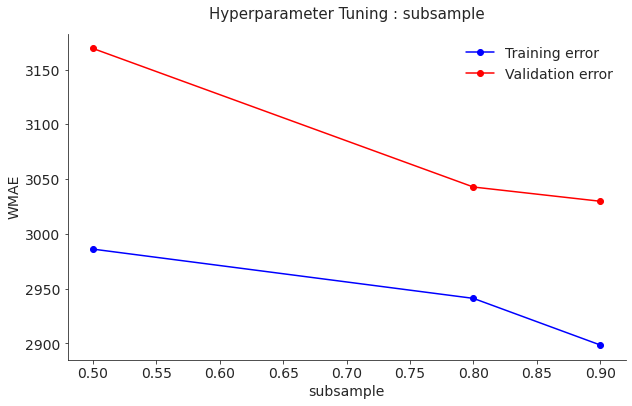

In [ ]:
hyper_param_name = 'subsample'
hyper_param_values = [0.5,0.8, 0.9]
         
plot_learning_curve(hyper_param_name,hyper_param_values,exp_train_errors,exp_val_errors)

######colsample_bytree

In [ ]:
exp_train_errors, exp_val_errors = [], []

In [ ]:
train_error, val_error = test_hyperparams(colsample_bytree = 0.8)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 3031.98, 'mae': 2904.19, 'rmse': 5098.7, 'adj_r2': 0.95, 'r2': 0.95} 
 Val Error(s):
 {'wmae': 3099.36, 'mae': 3024.42, 'rmse': 5176.06, 'adj_r2': 0.94, 'r2': 0.94}


In [ ]:
train_error, val_error = test_hyperparams(colsample_bytree = 0.9)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2992.24, 'mae': 2856.48, 'rmse': 4952.74, 'adj_r2': 0.95, 'r2': 0.95} 
 Val Error(s):
 {'wmae': 2996.2, 'mae': 2909.72, 'rmse': 4968.97, 'adj_r2': 0.95, 'r2': 0.95}


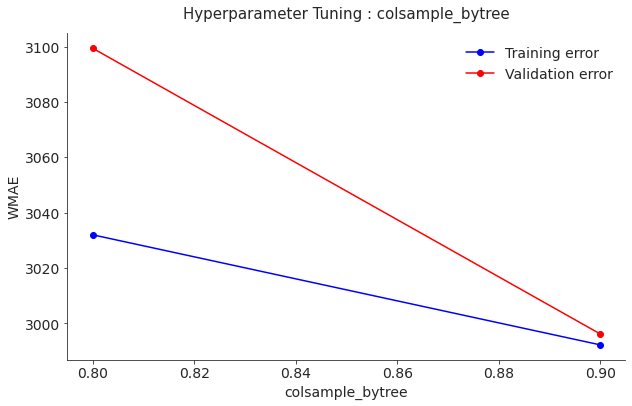

In [ ]:
hyper_param_name = 'colsample_bytree'
hyper_param_values = [0.8, 0.9]
          
plot_learning_curve(hyper_param_name,hyper_param_values,exp_train_errors,exp_val_errors)

###### learning_rate

In [ ]:
exp_train_errors, exp_val_errors = [], []

In [ ]:
train_error, val_error = test_hyperparams(learning_rate = 0.1)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 3958.08, 'mae': 3816.32, 'rmse': 6606.68, 'adj_r2': 0.92, 'r2': 0.92} 
 Val Error(s):
 {'wmae': 3829.53, 'mae': 3756.67, 'rmse': 6281.61, 'adj_r2': 0.92, 'r2': 0.92}


In [ ]:
train_error, val_error = test_hyperparams(learning_rate = 0.3)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(learning_rate = 0.5)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2611.35, 'mae': 2491.2, 'rmse': 4287.22, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2827.45, 'mae': 2744.68, 'rmse': 4655.72, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(learning_rate = 0.7)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2521.82, 'mae': 2400.22, 'rmse': 4081.52, 'adj_r2': 0.97, 'r2': 0.97} 
 Val Error(s):
 {'wmae': 2796.88, 'mae': 2744.53, 'rmse': 4672.09, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(learning_rate = 0.9)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2571.32, 'mae': 2439.76, 'rmse': 4161.99, 'adj_r2': 0.97, 'r2': 0.97} 
 Val Error(s):
 {'wmae': 3131.22, 'mae': 3072.14, 'rmse': 5132.61, 'adj_r2': 0.94, 'r2': 0.94}


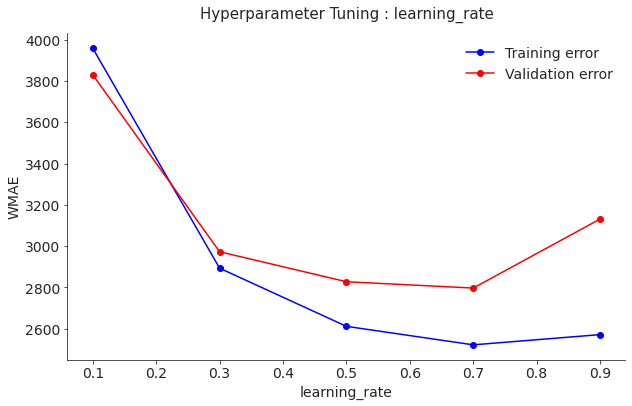

In [ ]:
hyper_param_name = 'learning_rate'
hyper_param_values = [0.1, 0.3, 0.5,0.7, 0.9]
         
plot_learning_curve(hyper_param_name,hyper_param_values,exp_train_errors,exp_val_errors)

###### gamma

In [ ]:
exp_train_errors, exp_val_errors = [], []

In [ ]:
train_error, val_error = test_hyperparams(gamma = 0)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(gamma = 1)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(gamma = 5)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(gamma = 20)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(gamma = 0.001)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2892.95, 'mae': 2783.55, 'rmse': 4810.32, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2972.63, 'mae': 2906.77, 'rmse': 4946.48, 'adj_r2': 0.95, 'r2': 0.95}


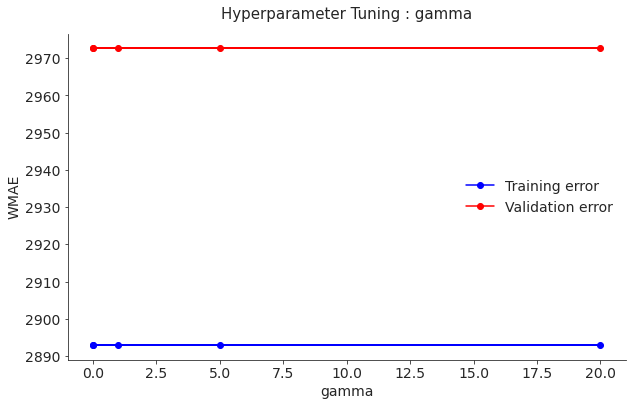

In [ ]:
hyper_param_name = 'gamma'
hyper_param_values = [0,1,5,20, 0.001]
plot_learning_curve(hyper_param_name,hyper_param_values,exp_train_errors,exp_val_errors)

###### reg_lambda

In [ ]:
exp_train_errors, exp_val_errors = [], []

In [ ]:
train_error, val_error = test_hyperparams(reg_lambda = 0.1)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2881.78, 'mae': 2768.76, 'rmse': 4722.39, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2974.7, 'mae': 2904.73, 'rmse': 4877.91, 'adj_r2': 0.95, 'r2': 0.95}


In [ ]:
train_error, val_error = test_hyperparams(reg_lambda = 0.001)
exp_train_errors.append(train_error['wmae'])
exp_val_errors.append(val_error['wmae'])

Train error(s):
 {'wmae': 2876.63, 'mae': 2756.49, 'rmse': 4831.11, 'adj_r2': 0.96, 'r2': 0.96} 
 Val Error(s):
 {'wmae': 2932.85, 'mae': 2850.86, 'rmse': 4865.4, 'adj_r2': 0.95, 'r2': 0.95}


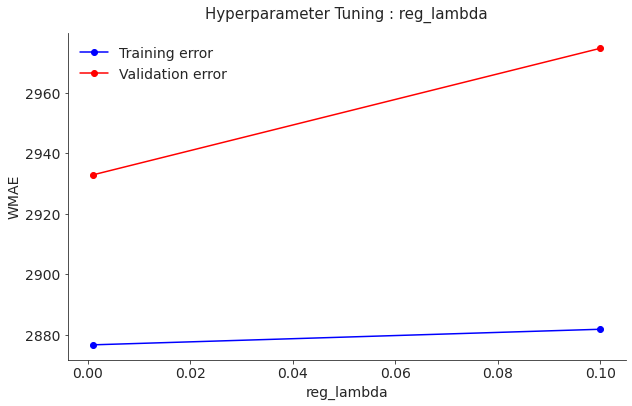

In [ ]:
hyper_param_name = 'reg_lambda'
hyper_param_values = [0.1, 0.001]
plot_learning_curve(hyper_param_name,hyper_param_values,exp_train_errors,exp_val_errors)

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm


'https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm'

###### Tuning them together

In [ ]:
X_train.columns

Index(['Store_Rank', 'Dept_Rank', 'Size', 'Type_A', 'Type_B', 'Type_C',
       'IsHoliday', 'WeekofYear', 'Month', 'Day', 'Year', 'BlackFriday_Week',
       'SuperBowl_Week', 'Christmas_Season', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'Fuel_Price', 'CPI',
       'Unemployment', 'Temperature'],
      dtype='object')

In [ ]:
%%time
model = XGBRegressor(random_state = 42, n_jobs = -1)
train_error, val_error = try_model(model, plot= False)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 2957.39, 'mae': 2859.76, 'rmse': 4926.57, 'adj_r2': 0.95, 'r2': 0.95} 
 Val Error(s):
 {'wmae': 3076.72, 'mae': 3011.19, 'rmse': 5091.5, 'adj_r2': 0.95, 'r2': 0.95}
CPU times: user 1min 16s, sys: 207 ms, total: 1min 16s
Wall time: 39.3 s


Let us use our observations to choose a starter set of Hyperparameters for our XGB Model. Hyperparameters work differently when combined. Since we are hand tuning we need to track the effect of reducing or increasing each of the hyperparameters keeping the others constant to arrive at a desired score.

Train error(s):
 {'wmae': 3734.82, 'mae': 3575.16, 'rmse': 6152.09, 'adj_r2': 0.93, 'r2': 0.93} 
 Val Error(s):
 {'wmae': 3721.14, 'mae': 3662.44, 'rmse': 6135.55, 'adj_r2': 0.92, 'r2': 0.92}
CPU times: user 27.4 s, sys: 175 ms, total: 27.6 s
Wall time: 26.6 s


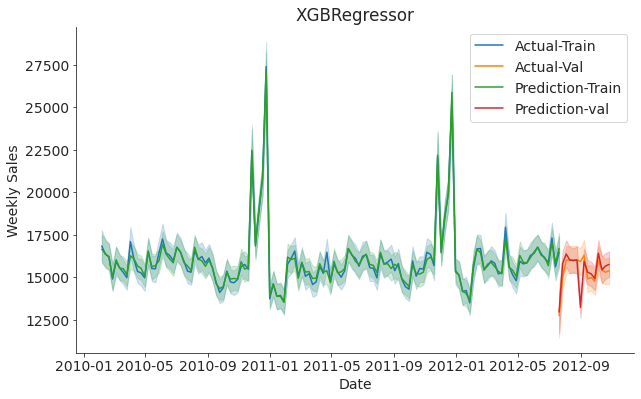

In [ ]:
%%time
xgb_hyper_params_starter = {
    'n_estimators': 100, # number of trees
    'max_depth': 5,     # very shallow trees
    'colsample_bytree': 0.9,  #Each tree uses 90% of the features
    'subsample': 0.5, # randomly sample half of the training data prior to growing trees
    'learning_rate':0.3,  #eta contribution of corrections from new trees added
    'reg_lambda': 0.001
}

if use_GPU:
  #With GPU
  xgb = XGBRegressor(random_state = 42, n_jobs = -1, tree_method = 'gpu_hist', **xgb_hyper_params_starter)
else:
  #without GPU
  xgb = XGBRegressor(random_state = 42, n_jobs = -1,**xgb_hyper_params_starter)

model = xgb
train_error, val_error = try_model(model, plot= True)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 250.33, 'mae': 262.58, 'rmse': 907.81, 'adj_r2': 1.0, 'r2': 1.0} 
 Val Error(s):
 {'wmae': 1654.68, 'mae': 1621.57, 'rmse': 3076.64, 'adj_r2': 0.98, 'r2': 0.98}
CPU times: user 9min 36s, sys: 3.12 s, total: 9min 39s
Wall time: 9min 21s


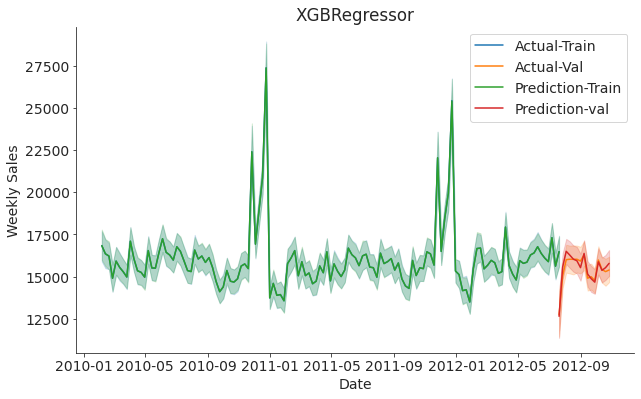

In [85]:
%%time
xgb_hyper_params_best = {
    'n_estimators': 500, # number of trees
    'max_depth': 15,     # depth of each tree
    'colsample_bytree': 0.9,  #Each tree uses 70% of the features
    'subsample': 0.9, # randomly sample training data prior to growing trees
    'learning_rate':0.2,  #eta contribution of corrections from new trees added
    #'reg_lambda': 0.001 #l2 regularisation
}
if use_GPU:
  #With GPU
  xgb = XGBRegressor(random_state = 42, n_jobs = -1, tree_method = 'gpu_hist', **xgb_hyper_params_best)
else:
  #without GPU
  xgb = XGBRegressor(random_state = 42, n_jobs = -1,**xgb_hyper_params_best)

model = xgb
train_error, val_error = try_model(model, plot= True)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

In [ ]:
#model = XGBRegressor(n_jobs= -1, random_state= 42, n_estimators= 500, max_depth= 15, 
#                     colsample_bytree= 0.9, subsample= 0.9, learning_rate= 0.2)

In [ ]:
xgb = model
xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

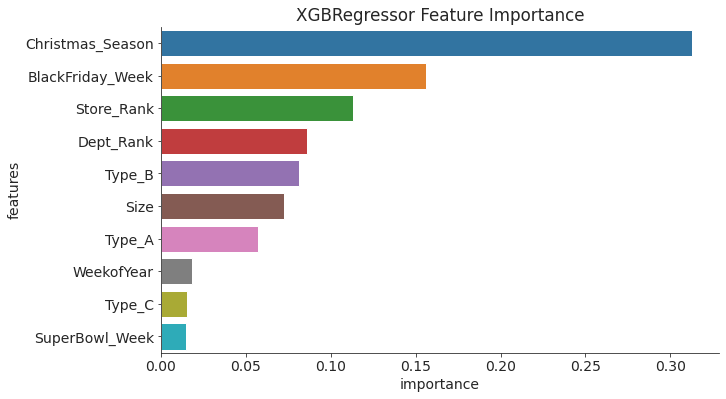

In [ ]:
model_name =  type(model).__name__
plot_importance(X_train.columns,model.feature_importances_, model_name)

In [ ]:
importance_df = pd.DataFrame({
                              'features': X_train.columns,
                              'importance': model.feature_importances_,
                              }).sort_values(by = 'importance', ascending= False)
importance_df

,features,importance
13,Christmas_Season,0.312966
11,BlackFriday_Week,0.156241
0,Store_Rank,0.112958
1,Dept_Rank,0.085830
4,Type_B,0.081203
2,Size,0.072591
3,Type_A,0.057407
7,WeekofYear,0.018314
5,Type_C,0.015399
12,SuperBowl_Week,0.014949


Our final choice of Hyperparameters have reduced the validation loss from a WMAE of \\$3,076 (no tuning) to \\$1,654 (xgb_hyper_params_best). This is an improvement of 46%. We have achieved a Kaggle Score of 3219 which is the top 34% of the leaderboard.

![](https://i.imgur.com/2zrXLg0.png)

We can use the same hyperparameters for RandomForest and LightGBM to see how both the models compare.  

## Random Forest



**What are some of the key hyperparameters for Random Forest?**  

`n_estimators` number of trees, control tree growth by depth `max_depth` , increase randomness by tuning `max_features` 

 

In [ ]:
%%time
model = RandomForestRegressor(random_state = 42, n_jobs = -1 )
train_error, val_error = try_model(model, plot= False)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 652.78, 'mae': 585.32, 'rmse': 1521.18, 'adj_r2': 1.0, 'r2': 1.0} 
 Val Error(s):
 {'wmae': 1596.01, 'mae': 1563.92, 'rmse': 3113.25, 'adj_r2': 0.98, 'r2': 0.98}
CPU times: user 9min 11s, sys: 1.35 s, total: 9min 12s
Wall time: 4min 42s


In [ ]:
max_depth_by_tree = [est.get_depth() for est in model.estimators_]
print( "average depth of trees: {}, number of trees: {}".format(np.mean(max_depth_by_tree), len(max_depth_by_tree)))

average depth of trees: 46.39, number of trees: 100


In [87]:
rf_hyper_params = {
    'n_estimators': 200,
    'max_depth': 40,
    'max_features': 0.9
}

In [88]:
rf = RandomForestRegressor(random_state = 42, n_jobs = -1,**rf_hyper_params )

In [89]:
%%time
model = rf
train_error, val_error = try_model(model, plot= False)
print("Train error(s):\n {} \n Val Error(s):\n {}".format(train_error, val_error))

Train error(s):
 {'wmae': 645.74, 'mae': 578.07, 'rmse': 1505.93, 'adj_r2': 1.0, 'r2': 1.0} 
 Val Error(s):
 {'wmae': 1551.72, 'mae': 1521.74, 'rmse': 2987.38, 'adj_r2': 0.98, 'r2': 0.98}
CPU times: user 15min 42s, sys: 2.98 s, total: 15min 45s
Wall time: 8min 2s


In [ ]:
rf = model
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=0.9, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

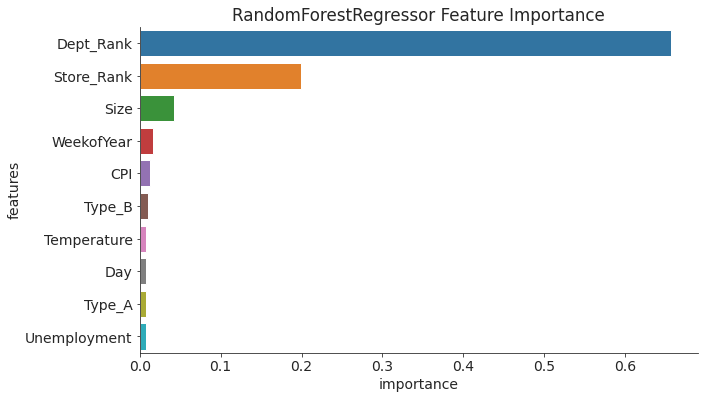

In [ ]:
model_name =  type(model).__name__
plot_importance(X_train.columns,model.feature_importances_, model_name)

Our final choice of Hyperparameters have reduced the validation loss from a WMAE of \\$1,596 to \\$1,557. We have achieved a Kaggle Score of 3272. This can be further improved.

![](https://i.imgur.com/TIiRggg.png)

## Light GBM

**What are some of the key hyperparameters for LightGBM?**

`num_leaves` to control growth by leaf ( as this is a key difference between XGBoost trees and LightGBM trees, `bagging_fraction` and `bagging_freq` are important hyperparameters to improve model performance.

In [ ]:
lgbm = LGBMRegressor(random_state = 42, n_jobs= -1)
lgbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        early_stopping_rounds=1000
        )
train_preds = lgbm.predict(X_train)
val_preds = lgbm.predict(X_val)

[1]	valid_0's l2: 4.00055e+08
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l2: 3.38532e+08
[3]	valid_0's l2: 2.88846e+08
[4]	valid_0's l2: 2.48916e+08
[5]	valid_0's l2: 2.1519e+08
[6]	valid_0's l2: 1.87042e+08
[7]	valid_0's l2: 1.64127e+08
[8]	valid_0's l2: 1.45271e+08
[9]	valid_0's l2: 1.30566e+08
[10]	valid_0's l2: 1.18292e+08
[11]	valid_0's l2: 1.08622e+08
[12]	valid_0's l2: 1.00145e+08
[13]	valid_0's l2: 9.36211e+07
[14]	valid_0's l2: 8.81899e+07
[15]	valid_0's l2: 8.33105e+07
[16]	valid_0's l2: 7.89496e+07
[17]	valid_0's l2: 7.5184e+07
[18]	valid_0's l2: 7.27139e+07
[19]	valid_0's l2: 6.92635e+07
[20]	valid_0's l2: 6.65453e+07
[21]	valid_0's l2: 6.37189e+07
[22]	valid_0's l2: 6.18773e+07
[23]	valid_0's l2: 6.00473e+07
[24]	valid_0's l2: 5.89442e+07
[25]	valid_0's l2: 5.78551e+07
[26]	valid_0's l2: 5.60462e+07
[27]	valid_0's l2: 5.52248e+07
[28]	valid_0's l2: 5.40994e+07
[29]	valid_0's l2: 5.31658e+07
[30]	valid_0's l2: 5.24937e+07
[31]	valid_0's l2:

In [ ]:
model_eval(X_train, y_train, train_preds)

{'adj_r2': 0.93, 'mae': 3712.95, 'r2': 0.93, 'rmse': 6218.18, 'wmae': 3840.59}

In [ ]:
model_eval(X_val, y_val, val_preds)

{'adj_r2': 0.92, 'mae': 3746.73, 'r2': 0.92, 'rmse': 6129.73, 'wmae': 3860.46}

In [ ]:
lgbm_hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'n_estimators': 1000,  
    'max_depth': 15,
    'sub_feature':0.9,       # % of features in each tree
    'learning_rate': 0.2,    
#Hyperparams that impact LGBM 
    'num_leaves': 32768, #  (2**max_depth)
    'bagging_fraction': 0.9, # % of random rows picked for each tree
    'bagging_freq': 10, # sampling will be done after every 10 iterations/trees
    'verbose': -1 # suppress logs
}

In [ ]:
%%time
lgbm = LGBMRegressor(**lgbm_hyper_params)
lgbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='l2',
        early_stopping_rounds=500
        )
train_preds = lgbm.predict(X_train, num_iteration=lgbm.best_iteration_)
val_preds = lgbm.predict(X_val, num_iteration=lgbm.best_iteration_)

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.9. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	valid_0's l1: 12096.1	valid_0's l2: 3.09426e+08
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l1: 9803.43	valid_0's l2: 2.02648e+08
[3]	valid_0's l1: 8009.4	valid_0's l2: 1.34835e+08
[4]	valid_0's l1: 6595.89	valid_0's l2: 9.14673e+07
[5]	valid_0's l1: 5474.15	valid_0's l2: 6.34866e+07
[6]	valid_0's l1: 4604.2	valid_0's l2: 4.55551e+07
[7]	valid_0's l1: 3927.66	valid_0's l2: 3.38996e+07
[8]	valid_0's l1: 3403.89	valid_0's l2: 2.62064e+07
[9]	valid_0's l1: 2996.95	valid_0's l2: 2.11085e+07
[10]	valid_0's l1: 2694.32	valid_0's l2: 1.77872e+07
[11]	valid_0's l1: 2446.74	valid_0's l2: 1.54

In [ ]:
lgbm

LGBMRegressor(bagging_fraction=0.9, bagging_freq=10, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.2, max_depth=15, metric=['l1', 'l2'],
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=32768,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, sub_feature=0.9, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, task='train',
              verbose=-1)

In [ ]:
model_eval( X_train,y_train, train_preds)

{'adj_r2': 0.99, 'mae': 1032.22, 'r2': 0.99, 'rmse': 2183.19, 'wmae': 1120.67}

In [ ]:
model_eval( X_val,y_val, val_preds)

{'adj_r2': 0.98, 'mae': 1657.48, 'r2': 0.98, 'rmse': 3145.69, 'wmae': 1705.96}

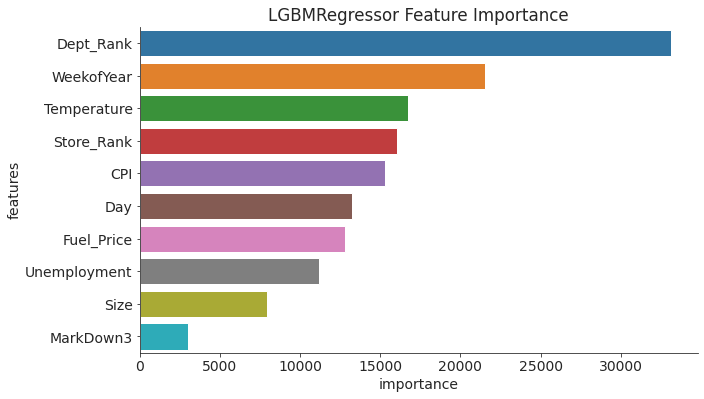

In [ ]:
model_name =  type(lgbm).__name__
plot_importance(X_train.columns,lgbm.feature_importances_, model_name)

Our final choice of Hyperparameters have reduced the validation loss from a WMAE of \\$3,860 (xgb_hyper_params_starter) to \\$1,698 (xgb_hyper_params_best). This is an improvement of 56%. We have achieved a Kaggle Score of 3,486. But it can surey benefit from more training as we can see from the top features that the model selected so far.

![](https://i.imgur.com/fIJeZM2.png)

## Making Predictions

In [ ]:
selected_model = xgb

In [ ]:
selected_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [ ]:
test_preds = selected_model.predict(inputs_test_df[input_cols])

In [ ]:
submission_df.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [ ]:
submission_df['Weekly_Sales'] = test_preds
submission_df.fillna(0, inplace= True)
submission_df.to_csv('./submission.csv', index= None)
!head submission.csv

Id,Weekly_Sales
1_1_2012-11-02,34526.78
1_1_2012-11-09,18766.379
1_1_2012-11-16,17498.297
1_1_2012-11-23,20471.764
1_1_2012-11-30,29249.908
1_1_2012-12-07,41684.332
1_1_2012-12-14,48679.79
1_1_2012-12-21,50859.3
1_1_2012-12-28,23630.818


## Save the best model

In [ ]:
import joblib

In [ ]:
walmart_weekly_sales_predictor_xgb = {
    'model': selected_model,
    'scaler': minmax_scaler,
    'encoder': onehot_encoder,
    'input_cols': select_input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': cat_cols,
    'encoded_cols': encoded_cols
}

In [ ]:
joblib.dump(walmart_weekly_sales_predictor_xgb, 'walmart_weekly_sales_predictor_xgb.joblib')

['walmart_weekly_sales_predictor_xgb.joblib']

In [ ]:
jovian.commit(outputs=['walmart_weekly_sales_predictor_xgb.joblib'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (walmart_weekly_sales_predictor_xgb.joblib)


Committed successfully! https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm


'https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm'

# Summary & Insights

In this notebook we explored Supervised Machine Learning methods. Regression models such as linear regression, decision tree and ensemble models such as RandomForest, XGBoost, LightGBM were trained to predict weekly sales using **Scikit Learn**, **LightGBM** and **XGBoost**.  We used **Pandas**, **Numpy**, **Matplotlib**, **Seaborn** and **Plotly** to perform the exploratory data analysis and gather insights for machine learning.

- Our dataset had 536,634 rows ( train = 421,570, test = 115,064) and 14 columns. 

-  We prepared the data by merging features with the train and test data sets, split the train data into train and val sets (90:10), imputed missing values (interpolaton, replace with 0), encoded categorical values ( `Type` - OneHot Encoding, `IsHoliday` : 0 & 1) and scaled the values using MinMaxScaler.

- We trained our models on a highly skewed data set with large outliers, negative values and zeros with bare minimal transformations. Our target variable didn't seem to have a linear relationship with the input variables. 

- Since Linear regression models assume a normal distribution and also have other assumptions of independence of variables -  multicollinearity, heteroskedacity etc, our linear regression model performed poorly.

- Decision trees performed better as they are non-linear models but they also tend to overfit the data if unbounded. While we can tune the hyperparameters to reduce overfitting we can also use more powerful ensemble models.

- Ensemble models such as Random Forest reduce overfitting by bagging the results of multiple decision trees. We also explored XGBoost and Light GBM which use boosting techniques by training a bunch of weaker models.

- **Random Forest** performed the best with simple inputs and no hyperparameter tuning or feature engineering with a **Kaggle score of \\2,904 (Top 14% of the public leaderboard**, Top score on the leaderboard was 2,301)    
simple_input_cols: `'Store_Rank', 'Dept_Rank','Size', 'IsHoliday','Type_A', 'Type_B', 'Type_C', 'WeekofYear','Year','Month', 'Day'` with a validation loss of \\$1,352.  


- **Feature Engineering**: We experimented with various features  based on EDA for Holidays, Markdowns, Store Ranking, etc and selected the following features for the next step.
`'Store_Rank', 'Dept_Rank','Size', 'Type_A', 'Type_B', 'Type_C','IsHoliday', 'WeekofYear','Month','Day','Year','BlackFriday_Week', 'SuperBowl_Week', 'Christmas_Season',  'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Fuel_Price', 'CPI', 'Unemployment','Temperature'` 

- **XGB had the best performance after hyperparameter tuning with a Kaggle Score of 3,219**, which was in the top 34% of the leaderboard.
Hyperparameters: `n_estimators': 500,  'max_depth': 15,  'colsample_bytree': 0.9, 'subsample': 0.9,  'learning_rate':0.2`  

 - **Best 10 predictors** of weekly sales were
 ![](https://i.imgur.com/SPQBD63.png)



**Comparing and Contrasting Ensemble models Random Forest, XG Boost and LightGBM compare and contrast?**

![](https://i.imgur.com/mswsUwQ.png)

XGBoost had the best performance but as we can see from the stats above, RandomForest and LightGBM model can be nearly as good with the right hyperparameter tuning.

# Learning & limitations

- Maintaining the Jovian model experiment tracker is highly recommended. Here is the link to my [Experiment tracker](https://docs.google.com/spreadsheets/d/1lEU9qBXgyIovoSxsqYVeplTbgkgS5nN1Gprg7YB-nRk/edit?usp=sharing)  
- Start with simplest 4-5 features and select a model without hyperparameter tuning. 
    - My first approach was heavily feature engineered, the XGB model worked very well on the train and val data but performed very poorly on the test set resulting in a Kaggle Score of 24, 840
    - Starting over with simple features resulted in a Kaggle score of 3,170

- Train, Val split should be carefully considered to mirror the test set or real world scenario. 
    - The best split was 90:10 for these scores.
    - 70:30 , split from Nov (62:38) were also tried.  
   
- Feature Selection and Encoding of Nominal columns
    - Store and Dept seem to have significant predictive power, but these are nominal categorial variables. Their values are from 1 to 45 and 1 to 99, a numbering which we don't have the reasons for. It is likely that the models are assigning importance based on these values. So we rank the stores and departments by average sales. These features improved improved model performance. But it is also possible that the numbering follows some internal ranking at Walmart.

- Others
    - Feature Engineering and Selection is more Art/Human- knowledge of the business, environment and intuition.
    - Hyperparameter tuning is more Science/Machine - A sound understanding of the model implementation will help tune better models and even extend their capabilities
    - Many small issues can trip us up if not careful while performing merging, groupby and transform.
    - Dates can be tricky to work with. For example leap year and week of the year have several peculiarities to be mindful of
    - Modular programming early on will help speed up experiments


# Suggestions for Future Work 
- Feature selection techniques such as PCA, Autoencoders etc
- Tune Lasso, Ridge, SGD models
- Optimal Hyperparameter tuning for example with RandomSearchCV
- Neural Network models such as LSTM
- Features from the target variable such as lag,aggregrate, rolling stats since we have time-series data
- Remove outliers and perform interventions post prediction
- Stacking models
- Cleaner and more robust pipeline for transformation
- Compare and contrast ARIMA, Prophet, Classical Machine Learning and Neural Network models


# References

**Tutorials**  
Linear Regression with Scikit-Learn [Jovian Aakash N S ](https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/linear-regression-with-scikit-learn)  
How to approach Machine Learning Problems [Jovian Aakash N S](https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/how-to-approach-machine-learning-problems)  
Gradient Boosting Machines with XGBoost [Jovian Aakash N S](https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/gradient-boosting-machines-with-xgboost)  

**Documentation**  
Scikit Learn Supervised Learning [documentation](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)  
Light GBM [documentation](https://lightgbm.readthedocs.io/en/latest/)  
XGBoost [documentation](https://xgboost.readthedocs.io/en/latest/)

**Books, Blogs and Kaggle Kernels**  
Forecasting: Principles and Practice, [Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp2/)  
Working with Time Series Data [Jake Vanderplas](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)  
A Gentle Introduction to Normality Tests in Python [Machine Learning Mastery](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)  
Understanding the Bias-Variance Tradeoff [Scott Fortmann](http://scott.fortmann-roe.com/docs/BiasVariance.html)  
Tune Learning Rate for Gradient Boosting with XGBoost in Python [Machine Learning Mastery](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/)   
Fine-tuning XGBoost in Python like a boss  [Félix Revert](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)  
XGBoost: “Hi I’m Gamma. What can I do for you?” [Data Science & Design by Laurae](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6 )   
How to Control Your XGBoost Model [Stephen Pardy](https://www.capitalone.com/tech/machine-learning/how-to-control-your-xgboost-model/)  
Xgboost bias variance trade-off and hyper-parameters tuning [Kehui Yao](https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/)   
Understanding LightGBM Parameters (and How to Tune Them) [MJ Bahmani](https://neptune.ai/blog/lightgbm-parameters-guide)  
Kaggle First Place entry [David Thaler](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125)  
EDA with time and space [Sangyeop Lee](https://www.kaggle.com/yepp2411/walmart-prediction-1-eda-with-time-and-space)    
EDA and Store Sales Predictions using XGB [Yasir Hussain](https://www.kaggle.com/yasirhussain1987/eda-and-store-sales-predictions-using-xgb?scriptVersionId=73463410)  
Machine Learning for Walmart Forecasting Sales [Nicolas Benavides](https://jovian.ai/nicolas-bs/walmart-m-l-project)  


In [86]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm


'https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm'